In [ ]:
import pandas as pd
import numpy as np
import ast
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [ ]:
ia_A_path = "full/ia_A.csv"
df_A = pd.read_csv(ia_A_path)

In [ ]:
ia_P_path = "full/ia_P.csv"
df_P = pd.read_csv(ia_P_path)

### Answers

In [ ]:
df_A_filtered = df_A[(df_A['repeated_reading_trial'] == False) & ((df_A['practice_trial'] == False))]

article_col='article_id'
difficulty_col='difficulty_level'
batch_col='article_batch'
paragraph_col='paragraph_id'
q_ind = 'same_critical_span'

df_A_filtered['text_id'] = (
    df_A_filtered[article_col].astype(str) + '_' +
    df_A_filtered[difficulty_col].astype(str) + '_' +
    df_A_filtered[batch_col].astype(str) + '_' +
    df_A_filtered[paragraph_col].astype(str) + '_' +
    df_A_filtered[q_ind].astype(str)
    )

df_A_hunters = df_A_filtered[df_A_filtered['question_preview'] == True].copy()
df_A_gatherers = df_A_filtered[df_A_filtered['question_preview'] == False].copy()

In [ ]:
def create_area_screen_loc(df):
    df = df.copy()
    for col in ['question', 'answer_1', 'answer_2', 'answer_3', 'answer_4']:
        df[col] = df[col].fillna('').astype(str)

    df['question_tokens'] = df['question'].str.split()
    df['1_tokens'] = df['answer_1'].str.split()
    df['2_tokens'] = df['answer_2'].str.split()
    df['3_tokens'] = df['answer_3'].str.split()
    df['4_tokens'] = df['answer_4'].str.split()

    df['question_len'] = df['question_tokens'].apply(len)
    df['1_len'] = df['1_tokens'].apply(len)
    df['2_len'] = df['2_tokens'].apply(len)
    df['3_len'] = df['3_tokens'].apply(len)
    df['4_len'] = df['4_tokens'].apply(len)

    def assign_area(group):
        q_len = group['question_len'].iloc[0]
        first_len = group['1_len'].iloc[0]
        second_len = group['2_len'].iloc[0]
        third_len = group['3_len'].iloc[0]
        fourth_len = group['4_len'].iloc[0]

        q_end = q_len - 1
        first_end = q_len + first_len - 1
        second_end = q_len + first_len + second_len - 1
        third_end = q_len + first_len + second_len + third_len - 1
        fourth_end = q_len + first_len + second_len + third_len + fourth_len

        index_id = group['IA_ID'] - 1

        conditions = [
            (index_id <= q_end),
            (index_id > q_end) & (index_id <= first_end),
            (index_id > first_end) & (index_id <= second_end),
            (index_id > second_end) & (index_id <= third_end),
            (index_id > third_end) & (index_id <= fourth_end)
        ]

        choices = ['question', 'answer_0', 'answer_1', 'answer_2', 'answer_3']
        group['area_screen_loc'] = np.select(conditions, choices, default='unknown')
        return group

    df_area_split = df.set_index(['TRIAL_INDEX', 'participant_id']).groupby(['TRIAL_INDEX', 'participant_id'], group_keys=False).apply(assign_area)
    return df_area_split

In [ ]:
def create_area_label(df):
    def get_screen_loc(row):
        if row['area_screen_loc'] == 'question':
            return 'question'
        elif row['area_screen_loc'].startswith('answer_'):
            answers_order = ast.literal_eval(row['answers_order'])
            idx = int(row['area_screen_loc'].split('_')[1])
            return f'answer_{answers_order[idx]}'
        return None

    df['area_label'] = df.apply(get_screen_loc, axis=1)
    return df

In [ ]:
def create_selected_answer_label(df):
    df = df.copy()
    df['answers_order'] = df['answers_order'].apply(ast.literal_eval)
    df['selected_answer_label'] = df.apply(lambda row: row['answers_order'][row['selected_answer_position']], axis=1)
    return df

In [ ]:
def process_dataframe(df, functions):
    for func in functions:
        print(func)
        df = func(df)
    return df.reset_index()

processing_functions = [
    create_area_screen_loc,
    create_area_label,
    create_selected_answer_label
]

df_base_features_h = process_dataframe(df_A_hunters, processing_functions)
df_base_features_g = process_dataframe(df_A_gatherers, processing_functions)

In [ ]:
def create_mean_area_dwell_time_answers(df):
    return df.groupby(['TRIAL_INDEX', 'participant_id', 'text_id','area_label', 'area_screen_loc', 'selected_answer_label', 'selected_answer_position'], as_index=False).agg(mean_dwell_time=("IA_DWELL_TIME", "mean"))

In [ ]:
hunters_dwells_a = create_mean_area_dwell_time_answers(df_base_features_h)
gatherers_dwells_a = create_mean_area_dwell_time_answers(df_base_features_g)

In [ ]:
def pivot_answers(df):
    dwell_wide = (
        df
        .pivot(
            index=['TRIAL_INDEX', 'participant_id', 'text_id'],
            columns='area_label',
            values='mean_dwell_time'
        )
        .rename_axis(None, axis=1)
        .reset_index()
    )

    loc_wide = (
        df
        .pivot(
            index=['TRIAL_INDEX', 'participant_id', 'text_id'],
            columns='area_label',
            values='area_screen_loc'
        )
        .add_prefix('loc_')
        .rename_axis(None, axis=1)
        .reset_index()
    )

    sel = (
        df
        [['TRIAL_INDEX', 'participant_id', 'text_id',
          'selected_answer_label', 'selected_answer_position']]
        .drop_duplicates()
    )

    ans_wide = (
        dwell_wide
        .merge(loc_wide, on=['TRIAL_INDEX', 'participant_id', 'text_id'])
        .merge(sel,      on=['TRIAL_INDEX', 'participant_id', 'text_id'])
    )

    ans_wide['dwell_selected'] = ans_wide.apply(
        lambda r: r[f"answer_{r.selected_answer_label}"], axis=1
    )
    ans_wide['screenloc_selected'] = ans_wide.apply(
        lambda r: r[f"loc_answer_{r.selected_answer_label}"], axis=1
    )
    return ans_wide

ans_wide_h = pivot_answers(hunters_dwells_a)
ans_wide_g = pivot_answers(gatherers_dwells_a)


### Texts

In [ ]:
df_P_f  = df_P[(df_P['repeated_reading_trial'] == False) & ((df_P['practice_trial'] == False))]

df_P_hunters = df_P_f[df_P_f['question_preview'] == True].copy()
df_P_gatherers = df_P_f[df_P_f['question_preview'] == False].copy()

In [ ]:
def create_mean_area_dwell_time_text(df):
    return df.groupby(['TRIAL_INDEX', 'participant_id', 'auxiliary_span_type'], as_index=False).agg(mean_dwell_time=("IA_DWELL_TIME", "mean"))

In [ ]:
hunters_dwells_p = create_mean_area_dwell_time_text(df_P_hunters)
gatherers_dwells_p = create_mean_area_dwell_time_text(df_P_gatherers)

In [ ]:
text_wide_h = (
    hunters_dwells_p
    .pivot(index=['TRIAL_INDEX','participant_id'],
           columns='auxiliary_span_type',
           values='mean_dwell_time')
    .reset_index()
)

text_wide_g = (
    gatherers_dwells_p
    .pivot(index=['TRIAL_INDEX','participant_id'],
           columns='auxiliary_span_type',
           values='mean_dwell_time')
    .reset_index()
)

### Merge Texts and Answers

In [ ]:
merged_h = pd.merge(text_wide_h, ans_wide_h,
                  on=['TRIAL_INDEX','participant_id'])

merged_g = pd.merge(text_wide_g, ans_wide_g,
                  on=['TRIAL_INDEX','participant_id'])

In [ ]:
merged_h

### Safe and Load

In [ ]:
merged_h.to_csv('merged_hunters.csv', index=False)
merged_g.to_csv('merged_gatherers.csv', index=False)

In [62]:
merged_h = pd.read_csv('merged_hunters.csv')
merged_g = pd.read_csv('merged_gatherers.csv')

### Simple Correlation

In [63]:
def corr_map_num(df):
    cols = ['critical', 'distractor', 'outside',
            'answer_A', 'answer_B', 'answer_C', 'answer_D',
            'dwell_selected']

    corr = df[cols].corr()

    plt.figure()
    plt.imshow(corr, interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(cols)), cols, rotation=45, ha='right')
    plt.yticks(range(len(cols)), cols)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.show()

In [64]:
def prop_map(df):

    text_cols = ['critical', 'distractor', 'outside']
    ans_cols  = ['answer_A', 'answer_B', 'answer_C', 'answer_D']

    df[[f"{c}_prop" for c in text_cols]] = df[text_cols].div(df[text_cols].sum(axis=1), axis=0)
    df[[f"{c}_prop" for c in ans_cols]]   = df[ans_cols].div(df[ans_cols].sum(axis=1), axis=0)

    df['selected_prop'] = df['dwell_selected'] / df[ans_cols].sum(axis=1)


    cols_prop = [f"{c}_prop" for c in text_cols + ans_cols] + ['selected_prop']
    corr_prop = df[cols_prop].corr()


    plt.figure()
    plt.imshow(corr_prop, interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(cols_prop)), cols_prop, rotation=45, ha='right')
    plt.yticks(range(len(cols_prop)), cols_prop)
    plt.title('Correlation Matrix Heatmap (Proportions)')
    plt.tight_layout()
    plt.show()

In [65]:
def ABC_corr(df):

    corr_crit_A = df['critical_prop'].corr(df['answer_A_prop'])
    corr_crit_B = df['critical_prop'].corr(df['answer_B_prop'])
    corr_dist_C = df['distractor_prop'].corr(df['answer_C_prop'])
    print(f"Correlation between critical dwell and answer_A dwell: {corr_crit_A:.3f}")
    print(f"Correlation between critical dwell and answer_B dwell: {corr_crit_B:.3f}")
    print(f"Correlation between distractor dwell and answer_C dwell: {corr_dist_C:.3f}")

    plt.figure()
    plt.scatter(df['critical'], df['answer_A'])
    plt.xlabel('Critical span dwell time (ms)')
    plt.ylabel('Answer_A dwell time (ms)')
    plt.title('Critical span vs. Answer_A dwell')
    plt.tight_layout()
    plt.show()


    plt.figure()
    plt.scatter(df['critical'], df['answer_B'])
    plt.xlabel('Critical span dwell time (ms)')
    plt.ylabel('Answer_B dwell time (ms)')
    plt.title('Critical span vs. Answer_B dwell')
    plt.tight_layout()
    plt.show()


    plt.figure()
    plt.scatter(df['distractor'], df['answer_C'])
    plt.xlabel('Distractor span dwell time (ms)')
    plt.ylabel('Answer_C dwell time (ms)')
    plt.title('Distractor span vs. Answer_C dwell')
    plt.tight_layout()
    plt.show()

In [66]:
merged_h.columns


Index(['TRIAL_INDEX', 'participant_id', 'critical', 'distractor', 'outside',
       'text_id', 'answer_A', 'answer_B', 'answer_C', 'answer_D', 'question',
       'loc_answer_A', 'loc_answer_B', 'loc_answer_C', 'loc_answer_D',
       'loc_question', 'selected_answer_label', 'selected_answer_position',
       'dwell_selected', 'screenloc_selected'],
      dtype='object')

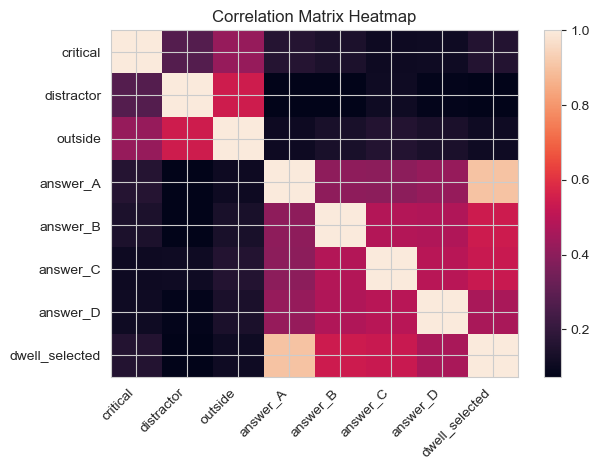

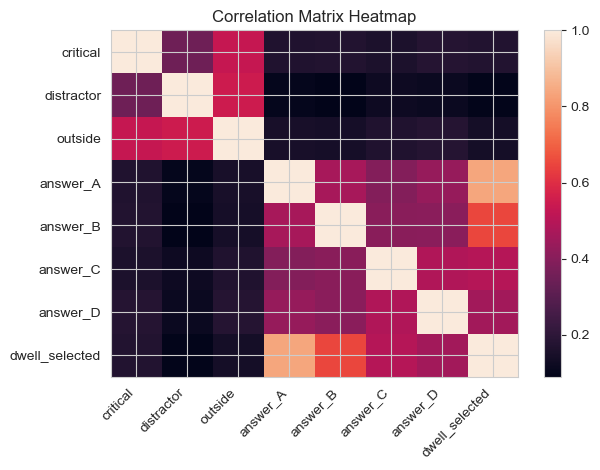

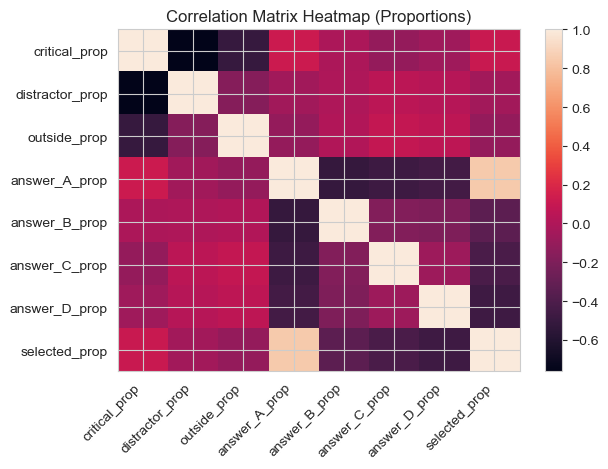

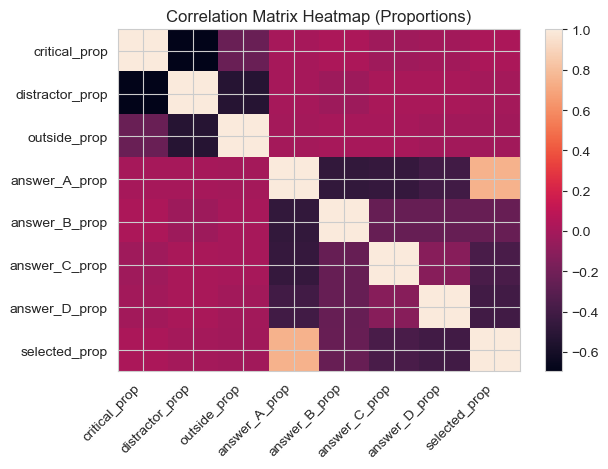

Correlation between critical dwell and answer_A dwell: 0.120
Correlation between critical dwell and answer_B dwell: -0.007
Correlation between distractor dwell and answer_C dwell: 0.053


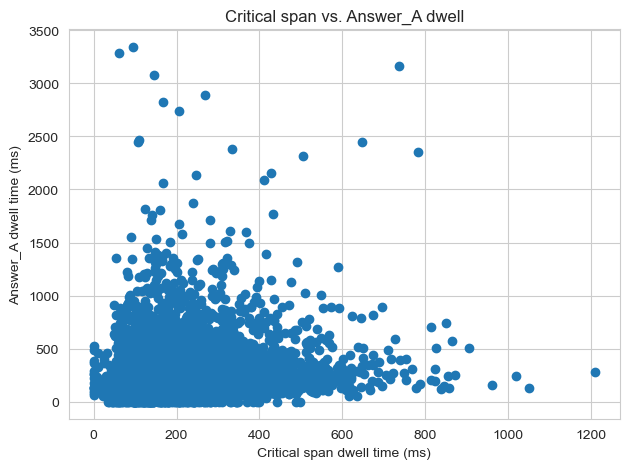

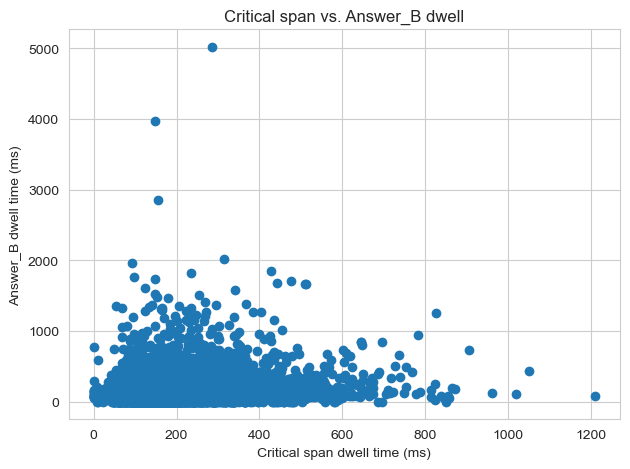

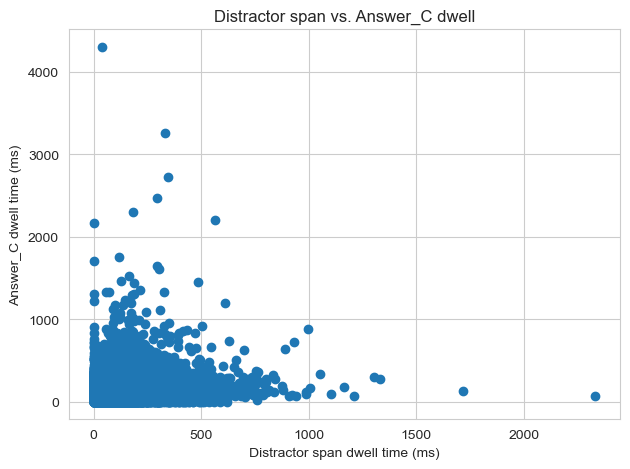

Correlation between critical dwell and answer_A dwell: 0.001
Correlation between critical dwell and answer_B dwell: 0.030
Correlation between distractor dwell and answer_C dwell: 0.014


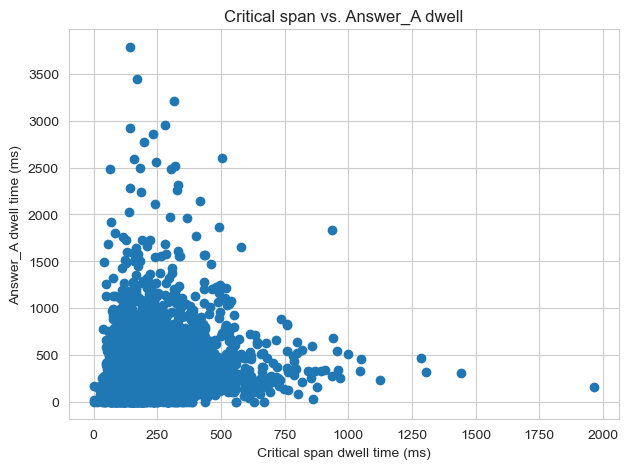

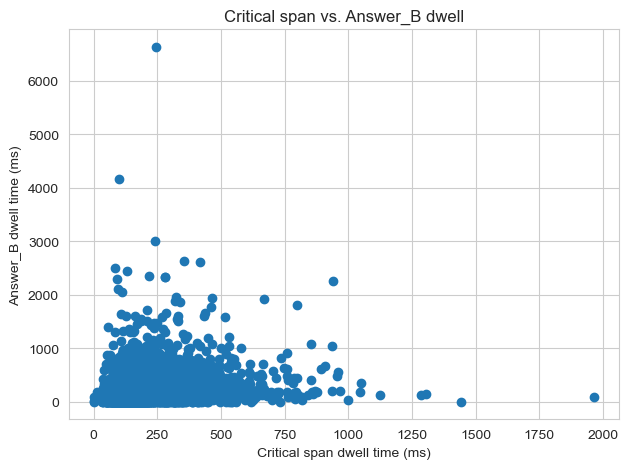

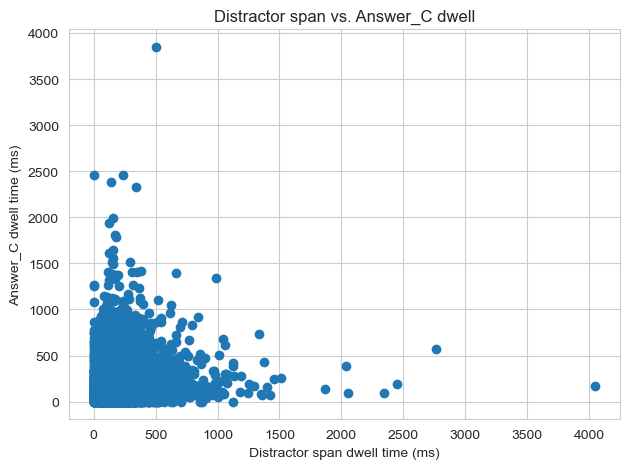

In [67]:
corr_map_num(merged_h)
corr_map_num(merged_g)

prop_map(merged_h)
prop_map(merged_g)

ABC_corr(merged_h)
ABC_corr(merged_g)

### Mixed Effects

In [68]:
merged_h['participant_id'] = merged_h['participant_id'].astype(str)
merged_h['text_id'] = merged_h['text_id'].astype(str)

In [69]:
!pip install pymer4

In [70]:
import warnings
warnings.filterwarnings("ignore", message=".*DataFrame.applymap.*", category=FutureWarning)

## No slopes

In [71]:
from pymer4.models import Lmer

def calc_corr_mixed_answ_separated(df, answer, text):
    df = df[df['selected_answer_label'] == answer[-1]]
    model = Lmer(f'{answer} ~ {text} + (1|participant_id) + (1|text_id)', data=df)
    result = model.fit()
    return model, result

In [72]:
def calc_corr_mixed_all_answ(df, answer, text):
    model = Lmer(f'{answer} ~ {text} + (1|participant_id) + (1|text_id)', data=df)
    result = model.fit()
    return model, result

In [73]:
def plot_fixed_effects(terms, models, h_or_g = 'hunters', separated='answ_separated'):
    effects = pd.concat([
        m.coefs.loc[terms, ["Estimate","SE"]]
          .assign(answer=a, term=lambda d: d.index,
                  ci_low=lambda d: d["Estimate"] - 1.96*d["SE"],
                  ci_high=lambda d: d["Estimate"] + 1.96*d["SE"])
        for a, m in models.items()
    ], ignore_index=True)

    x = np.arange(len(terms))
    answers = ["A","B","C","D"]
    offset = np.linspace(-0.3, 0.3, len(answers))

    term_color = {"critical":"#1f77b4", "distractor":"#ff7f0e", "outside":"#2ca02c"}
    markers    = {"A":"o", "B":"s", "C":"^", "D":"D"}  # circle, square, triangle, diamond

    fig, ax = plt.subplots(figsize=(8,4.5), dpi=140)

    for i, a in enumerate(answers):
        sub = effects[effects["answer"] == a].set_index("term").loc[terms]
        for j, t in enumerate(terms):
            est = sub.loc[t, "Estimate"]
            lo  = sub.loc[t, "ci_low"]
            hi  = sub.loc[t, "ci_high"]
            ax.errorbar(
                x[j] + offset[i], est,
                yerr=[[est - lo], [hi - est]],
                fmt=markers[a], ms=6,
                mfc=term_color[t], mec="black", mew=0.6,
                ecolor=term_color[t], elinewidth=1, capsize=3
            )

    ax.axhline(0, ls="--", lw=1, color="gray")
    ax.set_xticks(x)
    ax.set_xticklabels(["Critical","Distractor","Outside"])
    ax.set_ylabel("Coefficient")
    ax.set_title(f"Fixed effects by span - {h_or_g}")


    answer_handles = [Line2D([], [], marker=markers[a], linestyle="None",
                             markerfacecolor="white", markeredgecolor="black",
                             label=a) for a in answers]
    term_handles   = [Line2D([], [], marker="o", linestyle="None",
                             markerfacecolor=term_color[t], markeredgecolor="black",
                             label=t.capitalize()) for t in terms]

    leg1 = ax.legend(handles=answer_handles, title="Answers", loc="lower left", fontsize=8, title_fontsize=9)
    ax.add_artist(leg1)
    ax.legend(handles=term_handles, title="Text segment", loc="lower right", fontsize=8, title_fontsize=9)

    plt.tight_layout()
    plt.savefig(f'third_plots/text_to_answ/fixed_effects_by_span_{h_or_g} - {separated}')
    plt.show()


In [74]:
model_A_h, res_A_h = calc_corr_mixed_answ_separated(merged_h, 'answer_A', 'critical + distractor + outside')
model_B_h, res_B_h = calc_corr_mixed_answ_separated(merged_h, 'answer_B', 'critical + distractor + outside')
model_C_h, res_C_h = calc_corr_mixed_answ_separated(merged_h, 'answer_C', 'critical + distractor + outside')
model_D_h, res_D_h = calc_corr_mixed_answ_separated(merged_h, 'answer_D', 'critical + distractor + outside')

model_A_g, res_A_g = calc_corr_mixed_answ_separated(merged_g, 'answer_A', 'critical + distractor + outside')
model_B_g, res_B_g = calc_corr_mixed_answ_separated(merged_g, 'answer_B', 'critical + distractor + outside')
model_C_g, res_C_g = calc_corr_mixed_answ_separated(merged_g, 'answer_C', 'critical + distractor + outside')
model_D_g, res_D_g = calc_corr_mixed_answ_separated(merged_g, 'answer_D', 'critical + distractor + outside')

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by REML [’lmerMod’]
Formula: answer_A~critical+distractor+outside+(1|participant_id)+(1|text_id)

Family: gaussian	 Inference: parametric

Number of observations: 8449	 Groups: {'text_id': 970.0, 'participant_id': 180.0}

Log-likelihood: -56020.931 	 AIC: 112055.862

Random effects:

                       Name        Var      Std
text_id         (Intercept)  13724.583  117.152
participant_id  (Intercept)   2869.283   53.566
Residual                     27618.130  166.187

No random effect correlations specified

Fixed effects:

Model failed to converge with max|grad| = 0.00295769 (tol = 0.002, component 1) 

Linear mixed model fit by REML [’lmerMod’]
Formula: answer_B~critical+distr

In [75]:
model_A_h_all, res_A_h_all = calc_corr_mixed_all_answ(merged_h, 'answer_A', 'critical + distractor + outside')
model_B_h_all, res_B_h_all = calc_corr_mixed_all_answ(merged_h, 'answer_B', 'critical + distractor + outside')
model_C_h_all, res_C_h_all = calc_corr_mixed_all_answ(merged_h, 'answer_C', 'critical + distractor + outside')
model_D_h_all, res_D_h_all = calc_corr_mixed_all_answ(merged_h, 'answer_D', 'critical + distractor + outside')

model_A_g_all, res_A_g_all = calc_corr_mixed_all_answ(merged_g, 'answer_A', 'critical + distractor + outside')
model_B_g_all, res_B_g_all = calc_corr_mixed_all_answ(merged_g, 'answer_B', 'critical + distractor + outside')
model_C_g_all, res_C_g_all = calc_corr_mixed_all_answ(merged_g, 'answer_C', 'critical + distractor + outside')
model_D_g_all, res_D_g_all = calc_corr_mixed_all_answ(merged_g, 'answer_D', 'critical + distractor + outside')

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by REML [’lmerMod’]
Formula: answer_A~critical+distractor+outside+(1|participant_id)+(1|text_id)

Family: gaussian	 Inference: parametric

Number of observations: 9719	 Groups: {'text_id': 970.0, 'participant_id': 180.0}

Log-likelihood: -64588.586 	 AIC: 129191.173

Random effects:

                       Name        Var      Std
text_id         (Intercept)  12252.236  110.690
participant_id  (Intercept)   2848.325   53.370
Residual                     29241.383  171.001

No random effect correlations specified

Fixed effects:

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Co

In [76]:
t = ["critical", "distractor", "outside"]
mh = {"A": model_A_h, "B": model_B_h, "C": model_C_h, "D": model_D_h}
mg = {"A": model_A_g, "B": model_B_g, "C": model_C_g, "D": model_D_g}

In [77]:
mh_all = {"A": model_A_h_all, "B": model_B_h_all, "C": model_C_h_all, "D": model_D_h_all}
mg_all = {"A": model_A_g_all, "B": model_B_g_all, "C": model_C_g_all, "D": model_D_g_all}

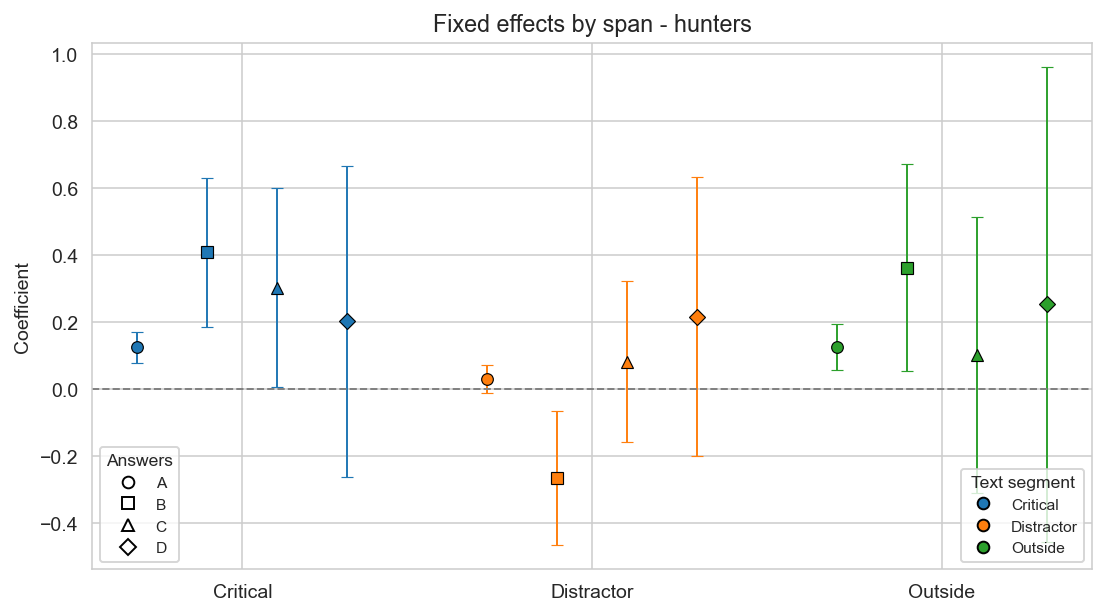

In [78]:
plot_fixed_effects(t, mh, 'hunters')

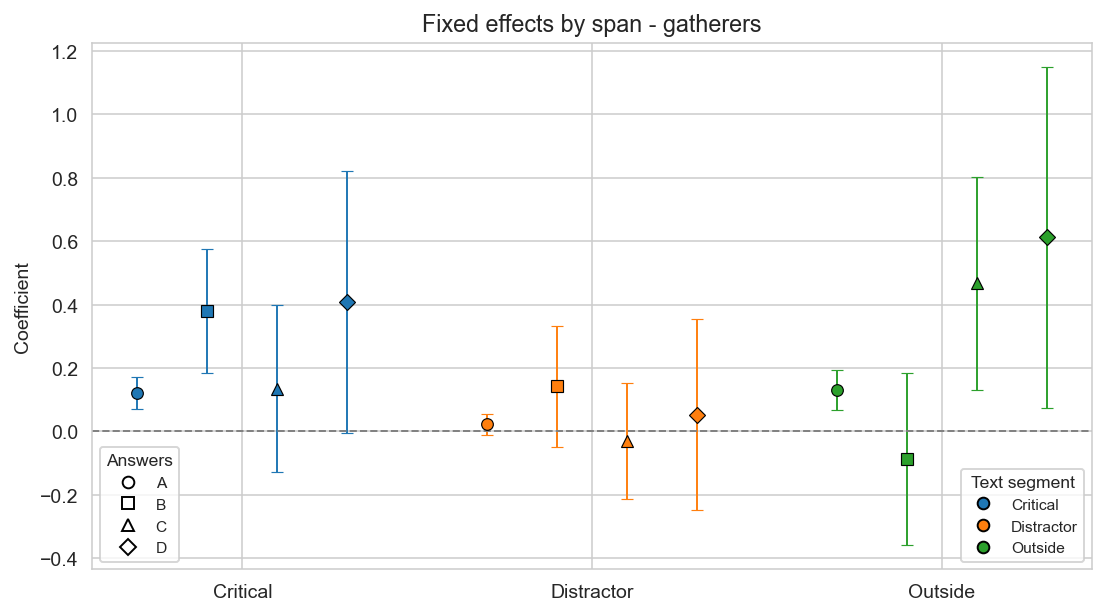

In [79]:
plot_fixed_effects(t, mg, 'gatherers')

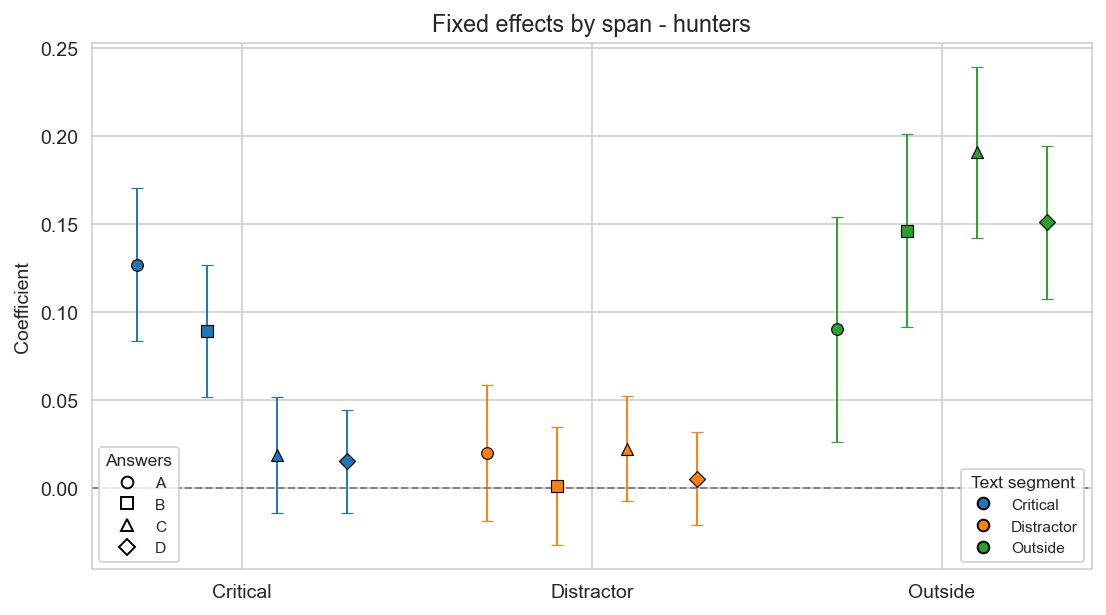

In [80]:
plot_fixed_effects(t, mh_all, 'hunters', separated='all_answ')

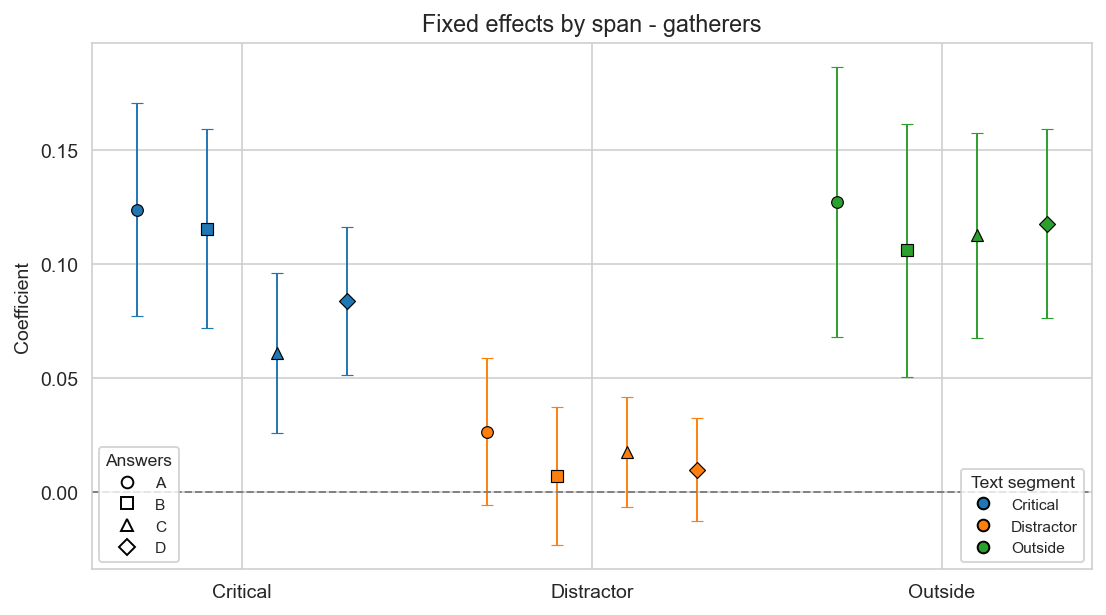

In [81]:
plot_fixed_effects(t, mg_all, 'gatherers', separated='all_answ')

## Slopes

In [82]:
def build_model(answer_col, df):
    df = df[df['selected_answer_label'] == answer_col[-1]]
    formula = (
        f"{answer_col} ~ critical + distractor + outside "
        f"+ (1 + critical + distractor + outside || participant_id) "
        f"+ (1 | text_id)"
    )
    m = Lmer(formula, data=df)
    m.fit()
    return m

In [83]:
def build_model_all_answ(answer_col, df):
    formula = (
        f"{answer_col} ~ critical + distractor + outside "
        f"+ (1 + critical + distractor + outside | participant_id) "
        f"+ (1 | text_id)"
    )
    m = Lmer(formula, data=df)
    m.fit()
    return m

In [84]:
TERMS  = ["critical","distractor","outside"]
COLORS = {"critical":"#1f77b4","distractor":"#ff7f0e","outside":"#2ca02c"}

def participant_effects(model, terms=TERMS):
    re = model.ranef[1].copy()
    if "(Intercept)" in re.columns:
        re = re.rename(columns={"(Intercept)":"Intercept"})
    re = re.reset_index().rename(columns={"index":"participant_id"})
    fix = model.coefs.loc[terms, "Estimate"]
    out = re[["participant_id","Intercept"]].rename(columns={"Intercept":"rand_intercept"})
    for t in terms:
        out[f"{t}_dev"] = re[t]
        out[t] = re[t] + fix[t]
    return out

def plot_participant_effects(model, answer_label, terms=TERMS, h_or_g='hunters'):
    eff = participant_effects(model, terms)

    coefs = model.coefs.loc[terms, ["Estimate","SE","P-val"]]
    print(f"\n=== {answer_label}: fixed effects ===")
    for t, row in coefs.iterrows():
        p = row["P-val"]
        stars = "***" if p<1e-3 else "**" if p<1e-2 else "*" if p<5e-2 else "." if p<1e-1 else ""
        print(f"{t:12s} β={row['Estimate']:.3f} ± {1.96*row['SE']:.3f}  p={p:.4g} {stars}")

    d = eff["rand_intercept"].sort_values().reset_index(drop=True)
    x = np.arange(len(d))
    plt.figure(figsize=(12,3), dpi=150)
    plt.errorbar(x, d, yerr=0, fmt="none")
    plt.vlines(x, 0, d, color="black", alpha=0.5, lw=1)
    plt.scatter(x, d, color="black", s=10)
    plt.axhline(0, color="black", lw=1)
    plt.title(f"Random intercepts (baseline answer time) — {answer_label}")
    plt.xlabel("Participant (sorted)"); plt.ylabel("Random intercept")
    plt.savefig(f'third_plots/text_to_answ/personalized_slopes/{answer_label}_intercept_{h_or_g}.png')
    plt.grid(axis="y", alpha=0.2); plt.tight_layout(); plt.show()

    for t in terms:
        sd = eff[f"{t}_dev"].std(ddof=1)
        d = eff[t].sort_values().reset_index(drop=True)
        x = np.arange(len(d))
        yerr = np.full_like(d.values, 1.96*sd, dtype=float)

        plt.figure(figsize=(12,3), dpi=150)
        plt.errorbar(x, d, yerr=yerr, fmt="none", ecolor=COLORS[t], alpha=0.7, capsize=2, lw=1, zorder=1)
        plt.vlines(x, 0, d, color=COLORS[t], alpha=0.4, lw=1, zorder=2)
        plt.scatter(x, d, color=COLORS[t], s=12, zorder=3)

        plt.axhline(0, color="black", lw=1)
        plt.axhline(d.mean(), color="gray", ls="--", lw=1, label="Mean")
        plt.axhline(np.median(d), color="gray", ls="-.", lw=1, label="Median")
        plt.title(f"Participant-specific effect of {t.capitalize()} — {answer_label} (±1.96·SD dev)")
        plt.xlabel("Participant (sorted)")
        plt.ylabel("Effect (ms per unit)")
        plt.grid(axis="y", alpha=0.2); plt.legend(loc="upper left")
        plt.tight_layout()
        plt.savefig(f'third_plots/text_to_answ/personalized_slopes/{answer_label}_{t}_{h_or_g}.png')
        plt.show()


In [85]:
model_A_sloped_h = build_model("answer_A", merged_h)
model_B_sloped_h = build_model("answer_B", merged_h)
model_C_sloped_h = build_model("answer_C", merged_h)
model_D_sloped_h = build_model("answer_D", merged_h)

model_A_sloped_g = build_model("answer_A", merged_g)
model_B_sloped_g = build_model("answer_B", merged_g)
model_C_sloped_g = build_model("answer_C", merged_g)
model_D_sloped_g = build_model("answer_D", merged_g)


[1] "Model failed to converge with max|grad| = 5.2593 (tol = 0.002, component 1)"
[2] " \n"                                                                        

[1] "Model is nearly unidentifiable: very large eigenvalue\n - Rescale variables?"
[2] " \n"                                                                         

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by REML [’lmerMod’]
Formula: answer_A~critical+distractor+outside+(1+critical+distractor+outside||participant_id)+(1|text_id)

Family: gaussian	 Inference: parametric

Number of observations: 8449	 Groups: {'text_id': 970.0, 'participant_id': 180.0}

Log-likelihood: -55998.677 	 AIC: 112017.353

Random effects:

                         Name        Var      

In [86]:
model_A_sloped_h_all = build_model_all_answ("answer_A", merged_h)
model_B_sloped_h_all = build_model_all_answ("answer_B", merged_h)
model_C_sloped_h_all = build_model_all_answ("answer_C", merged_h)
model_D_sloped_h_all = build_model_all_answ("answer_D", merged_h)

model_A_sloped_g_all = build_model_all_answ("answer_A", merged_g)
model_B_sloped_g_all = build_model_all_answ("answer_B", merged_g)
model_C_sloped_g_all = build_model_all_answ("answer_C", merged_g)
model_D_sloped_g_all = build_model_all_answ("answer_D", merged_g)

boundary (singular) fit: see help('isSingular') 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by REML [’lmerMod’]
Formula: answer_A~critical+distractor+outside+(1+critical+distractor+outside|participant_id)+(1|text_id)

Family: gaussian	 Inference: parametric

Number of observations: 9719	 Groups: {'text_id': 970.0, 'participant_id': 180.0}

Log-likelihood: -64580.481 	 AIC: 129192.961

Random effects:

                       Name        Var      Std
text_id         (Intercept)  12309.858  110.950
participant_id  (Intercept)      0.000    0.003
participant_id     critical      0.024    0.155
participant_id   distractor      0.022    0.149
participant_id      outside      0.044    0.209
Residual                     29025.172  1


=== Answer A: fixed effects ===
critical     β=0.099 ± 0.052  p=0.000255 ***
distractor   β=0.028 ± 0.045  p=0.2184 
outside      β=0.117 ± 0.072  p=0.001631 **


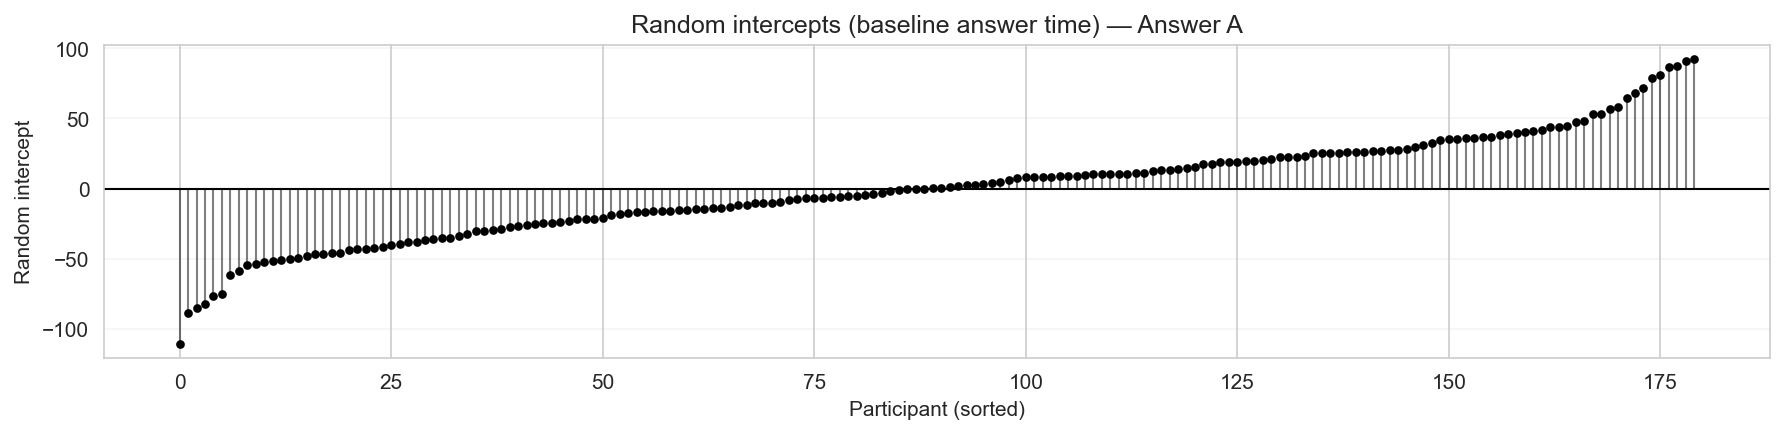

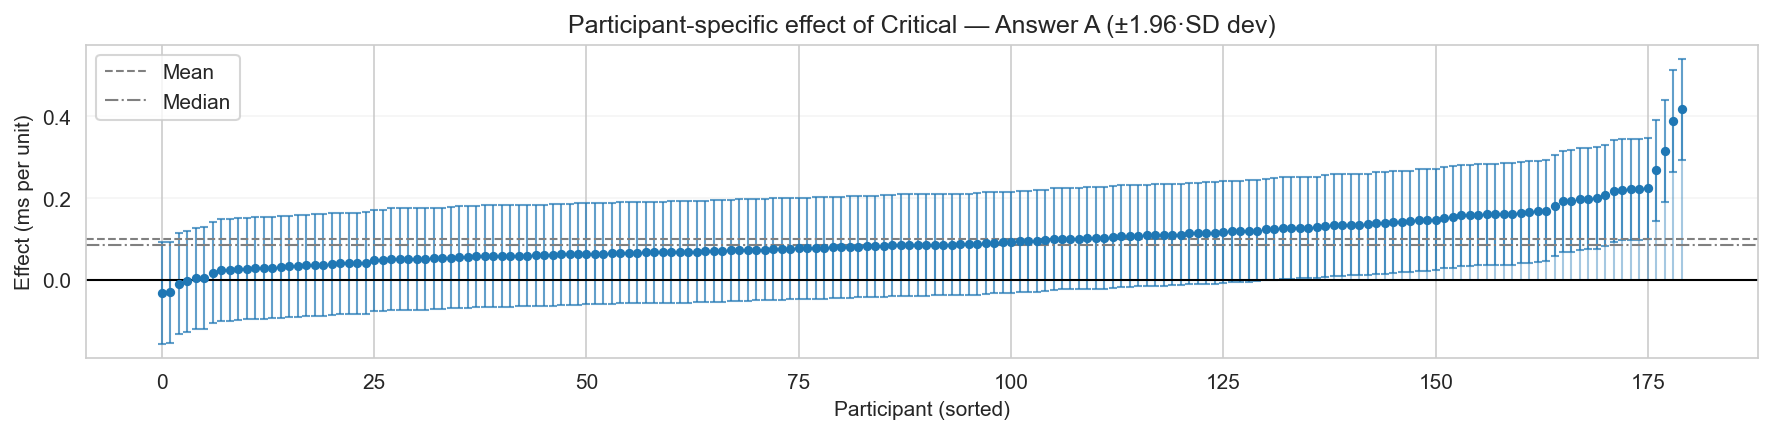

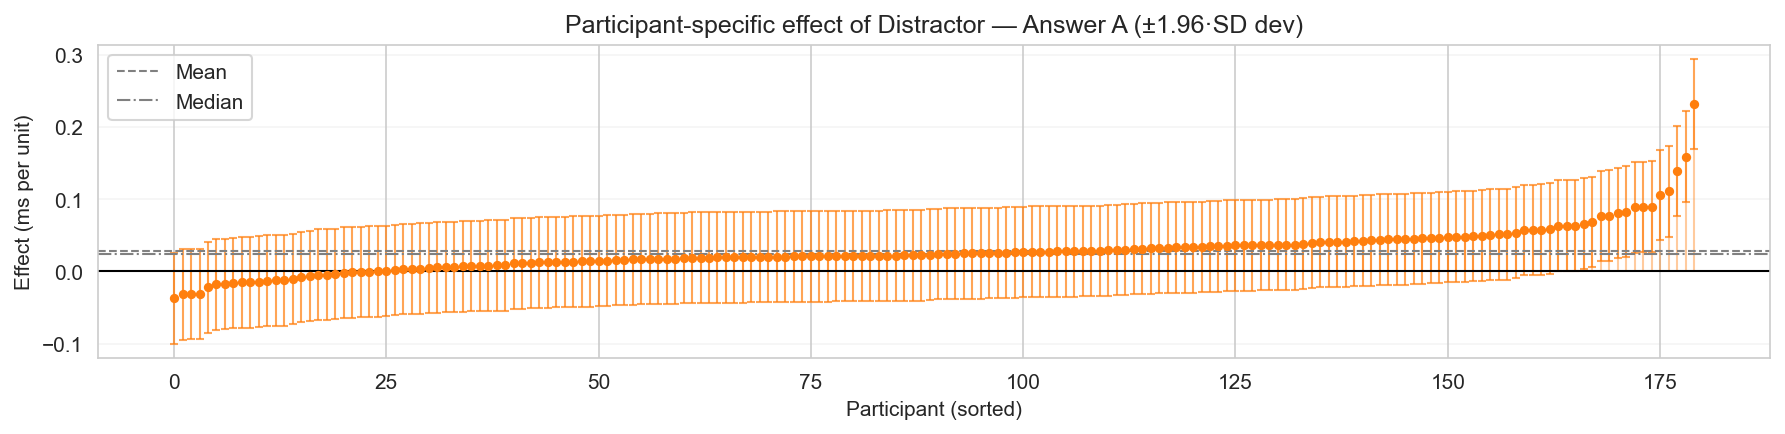

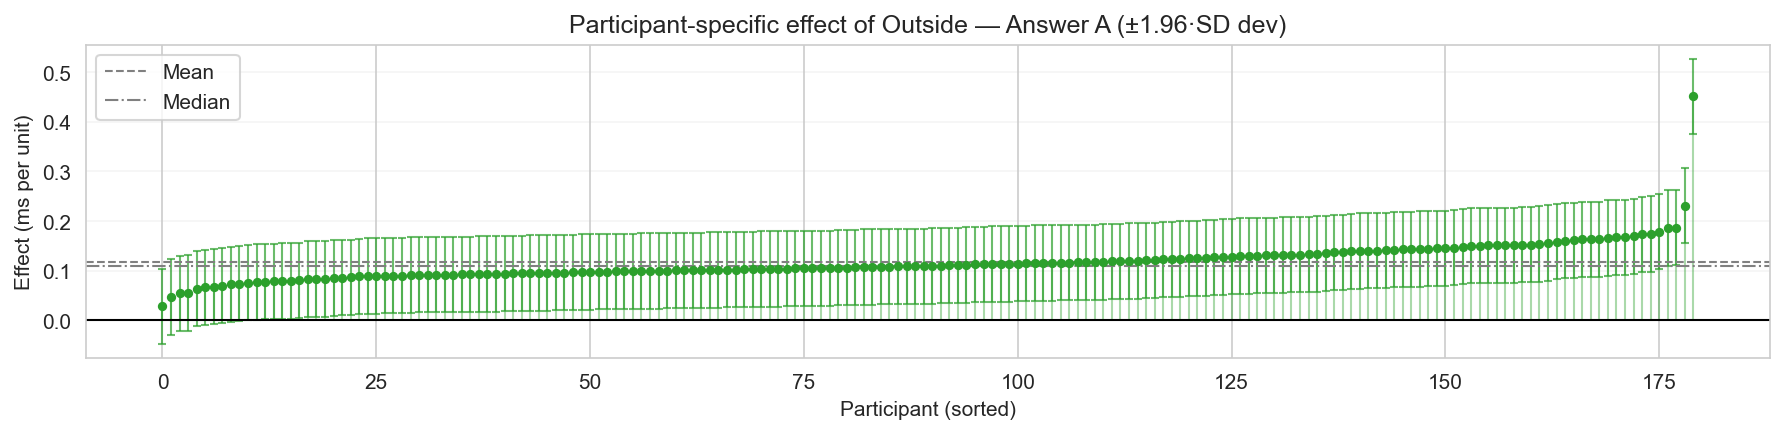


=== Answer B: fixed effects ===
critical     β=0.326 ± 0.263  p=0.0159 *
distractor   β=-0.254 ± 0.198  p=0.01272 *
outside      β=0.305 ± 0.309  p=0.07515 .


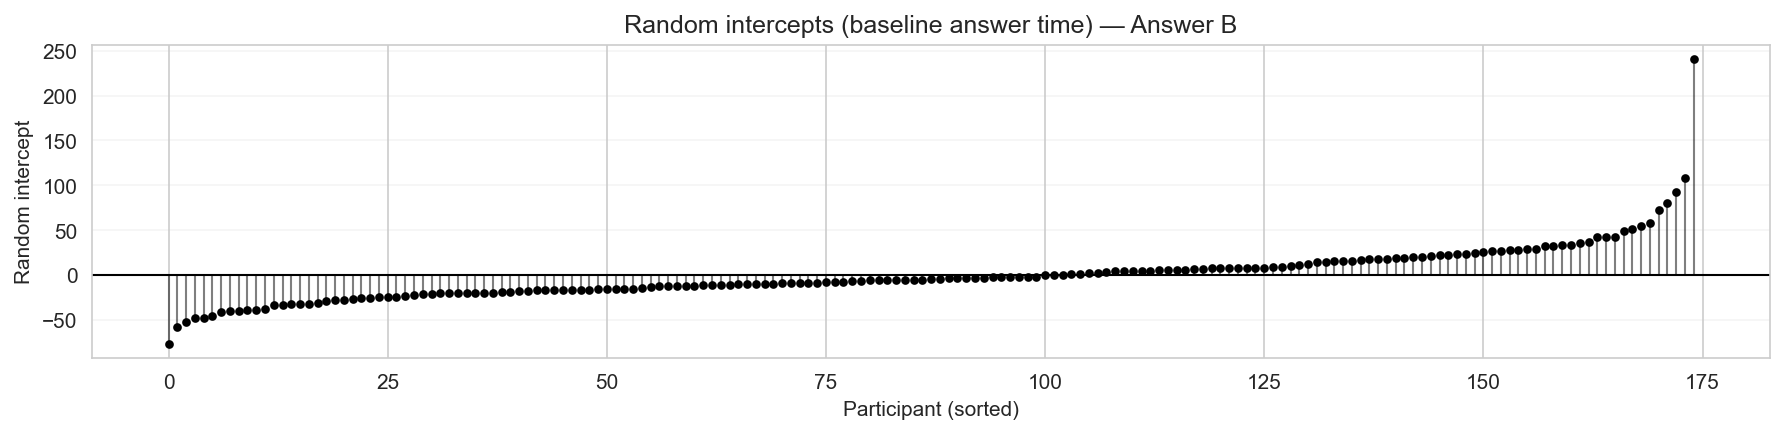

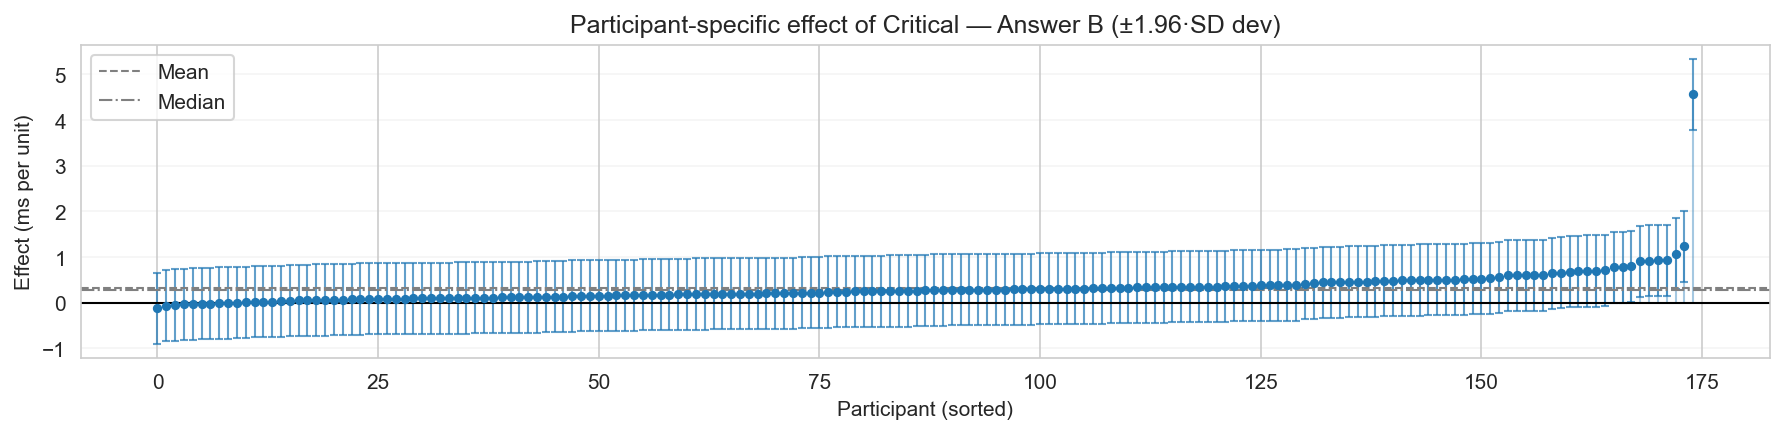

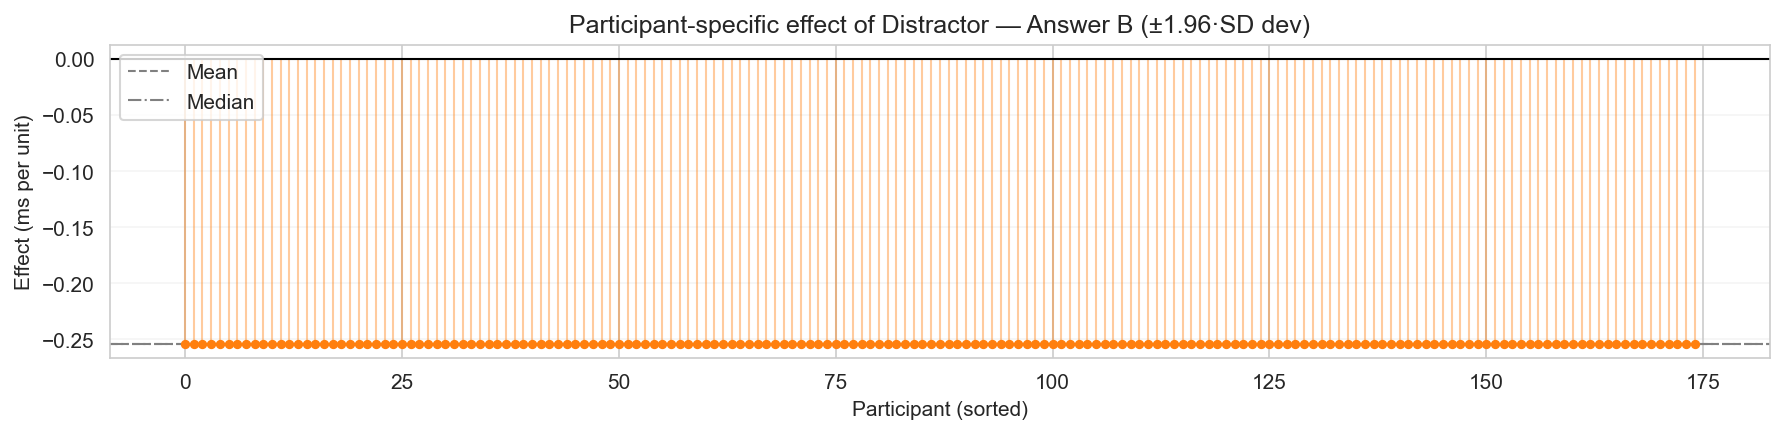

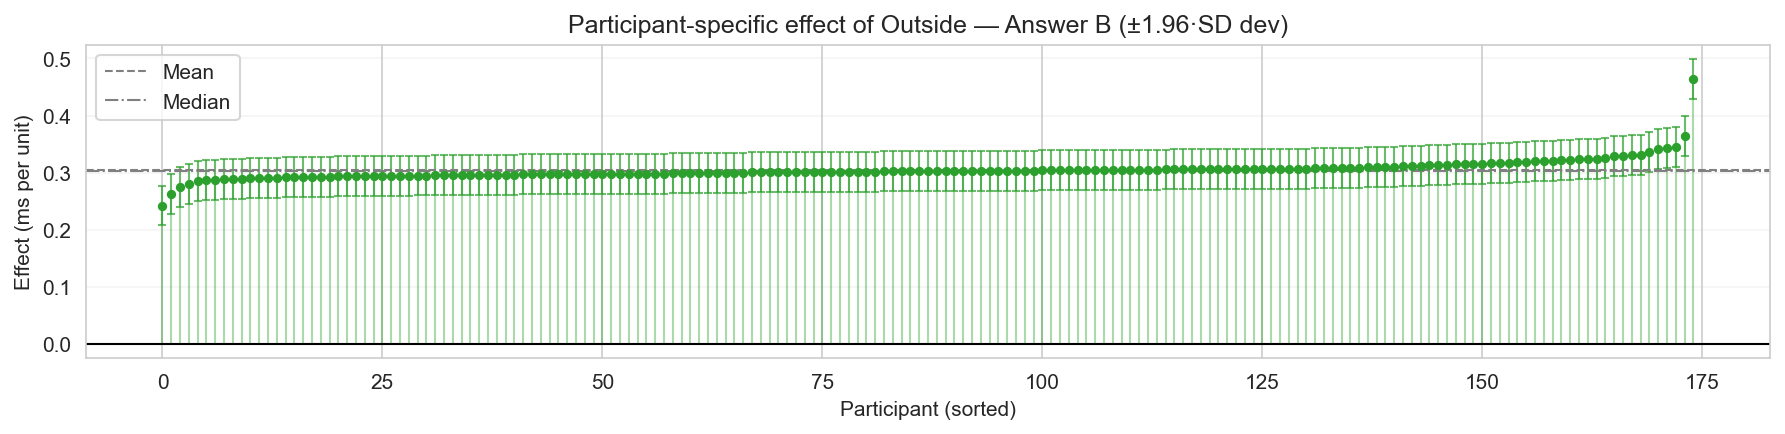


=== Answer C: fixed effects ===
critical     β=0.284 ± 0.298  p=0.06272 .
distractor   β=0.058 ± 0.261  p=0.6642 
outside      β=0.115 ± 0.416  p=0.5878 


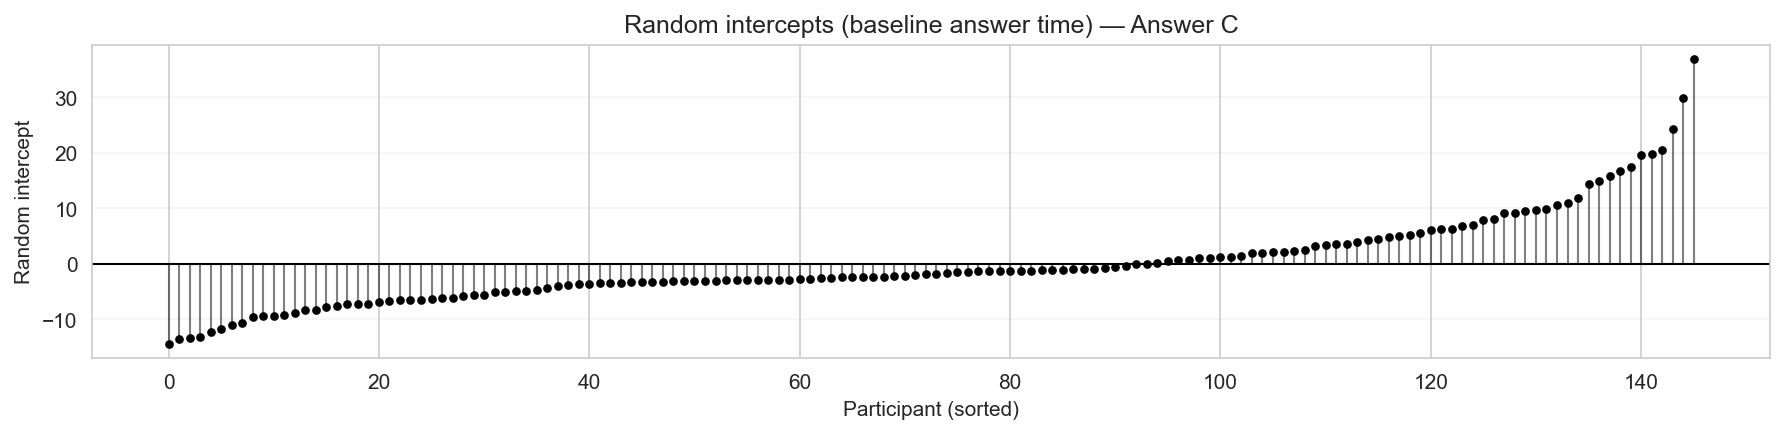

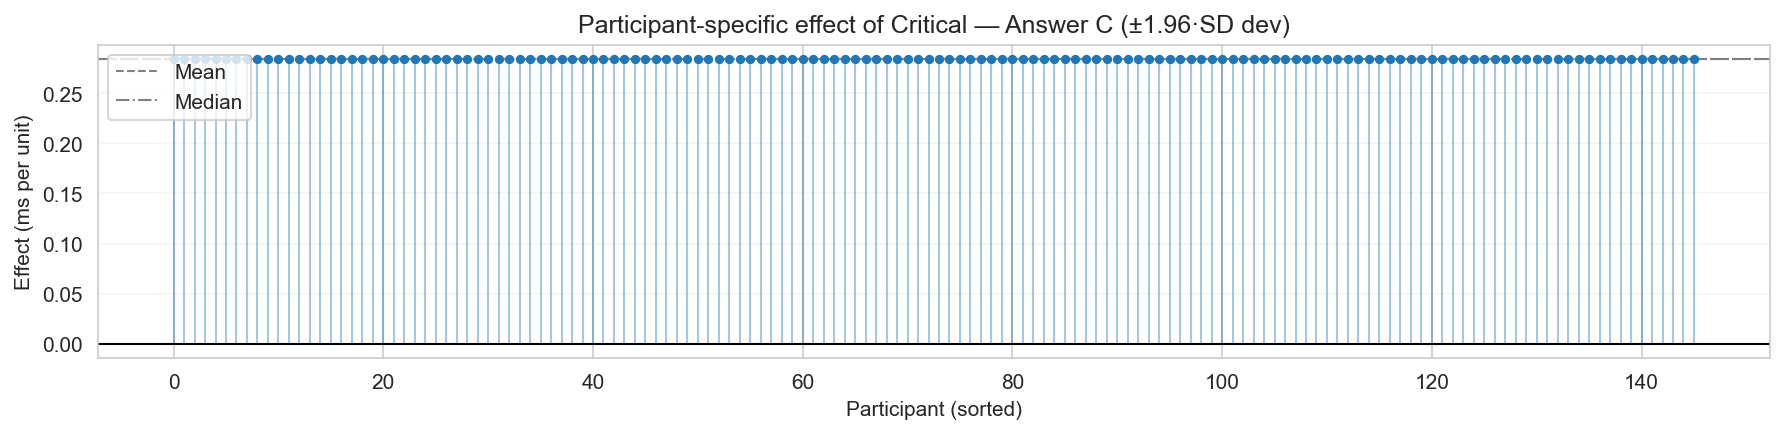

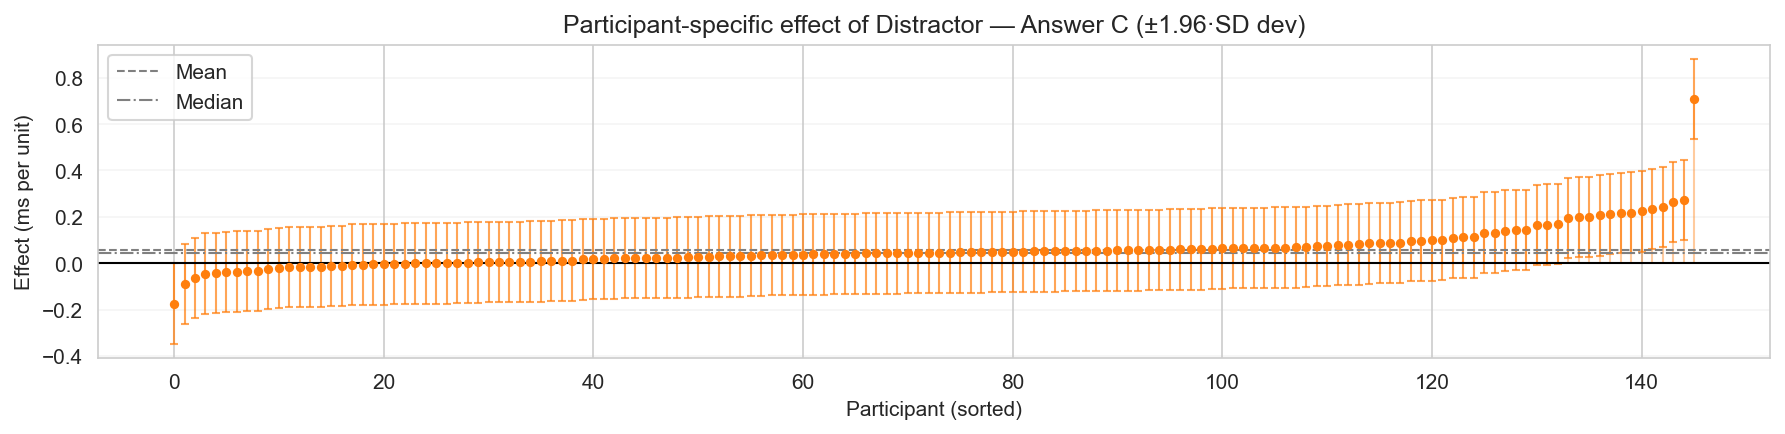

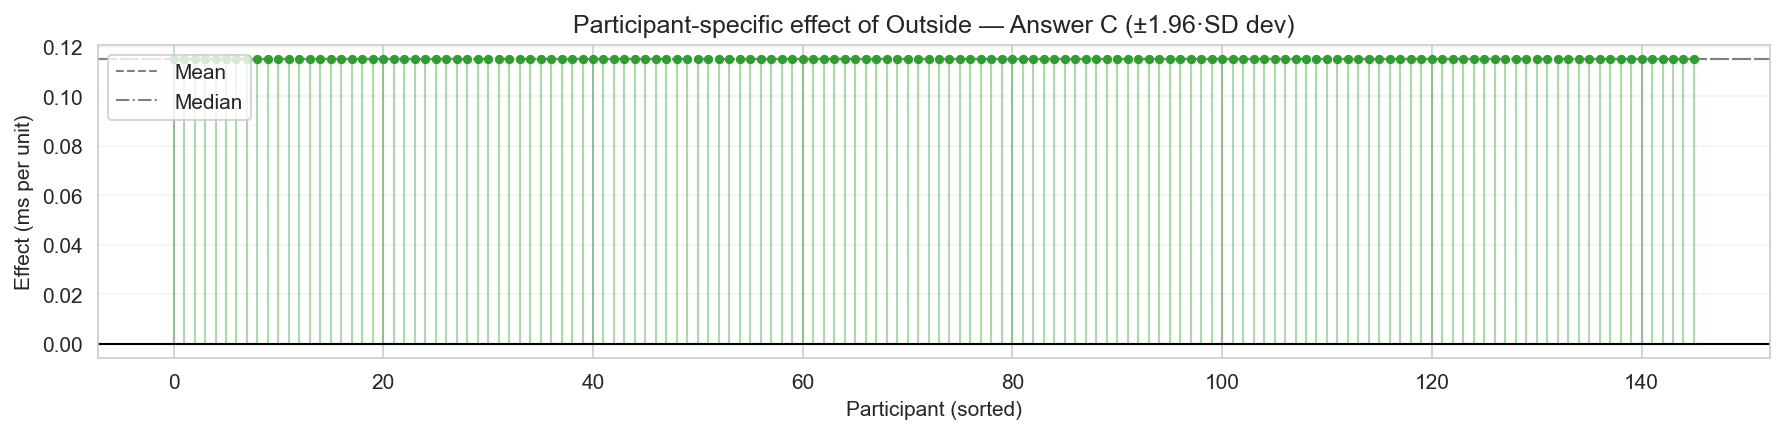


=== Answer D: fixed effects ===
critical     β=0.177 ± 0.477  p=0.469 
distractor   β=0.266 ± 0.415  p=0.212 
outside      β=0.267 ± 0.725  p=0.4726 


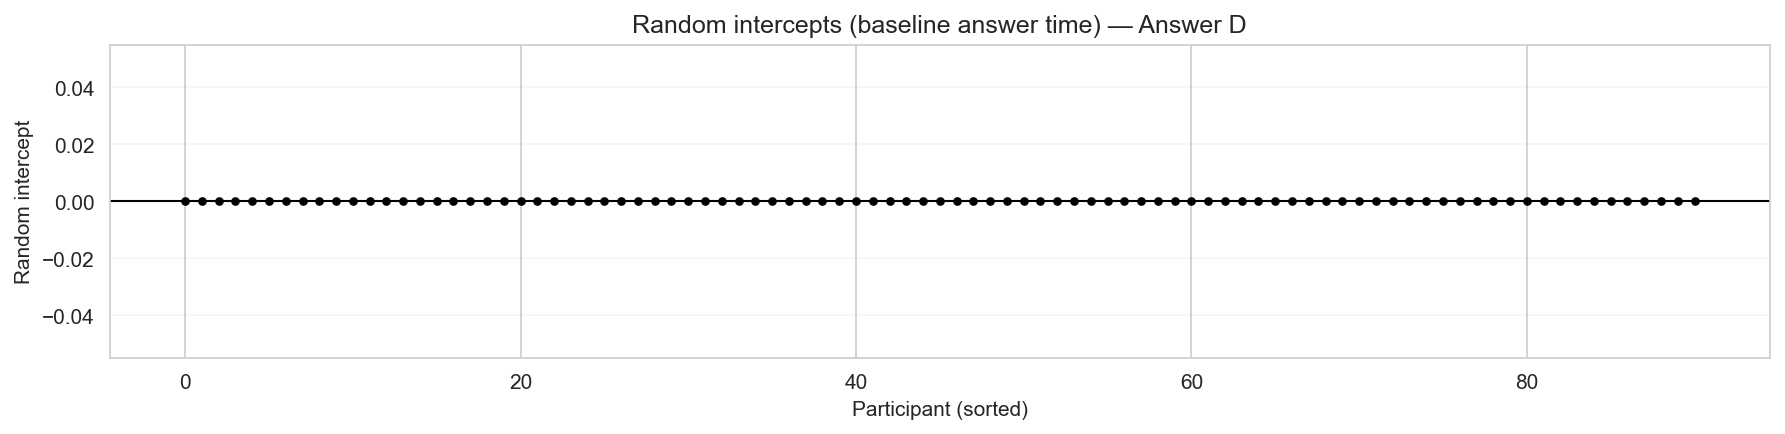

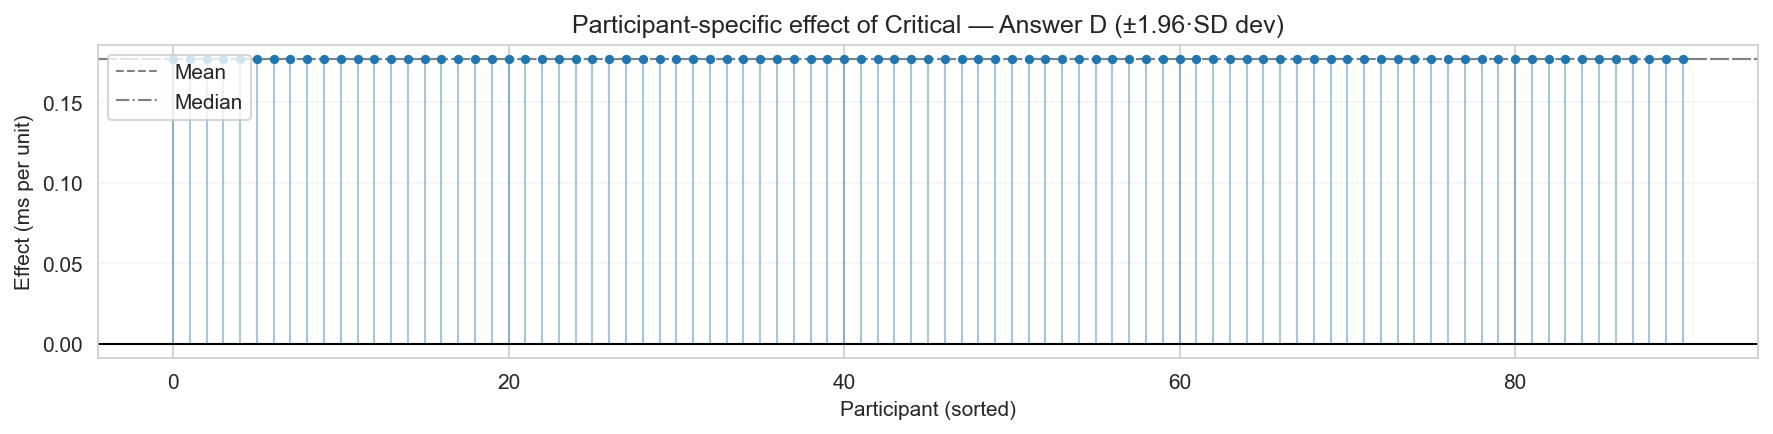

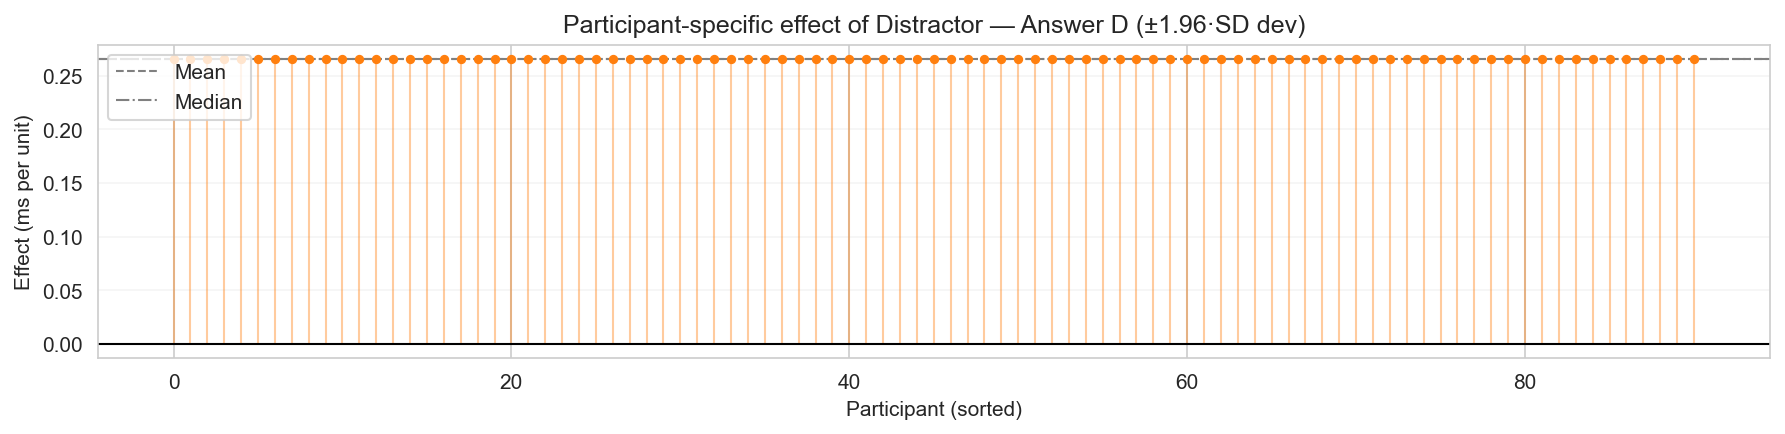

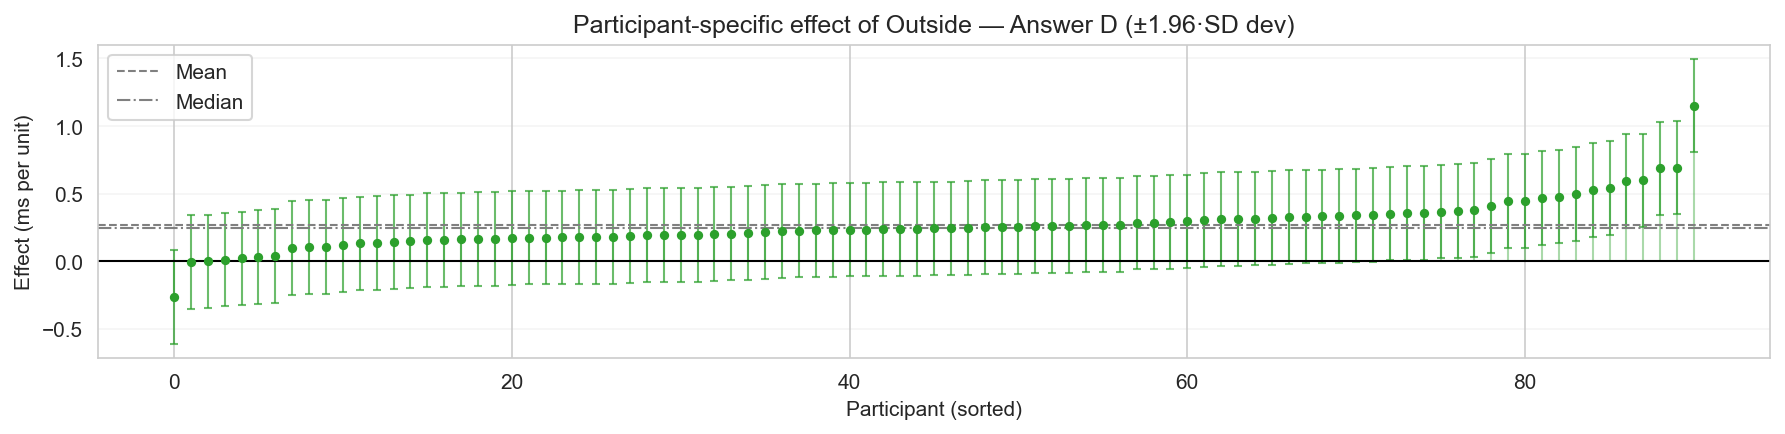

In [87]:
eff_A = plot_participant_effects(model_A_sloped_h, "Answer A")
eff_B = plot_participant_effects(model_B_sloped_h, "Answer B")
eff_C = plot_participant_effects(model_C_sloped_h, "Answer C")
eff_D = plot_participant_effects(model_D_sloped_h, "Answer D")


=== Answer A: fixed effects ===
critical     β=0.100 ± 0.067  p=0.003317 **
distractor   β=0.042 ± 0.039  p=0.03326 *
outside      β=0.162 ± 0.069  p=5.127e-06 ***


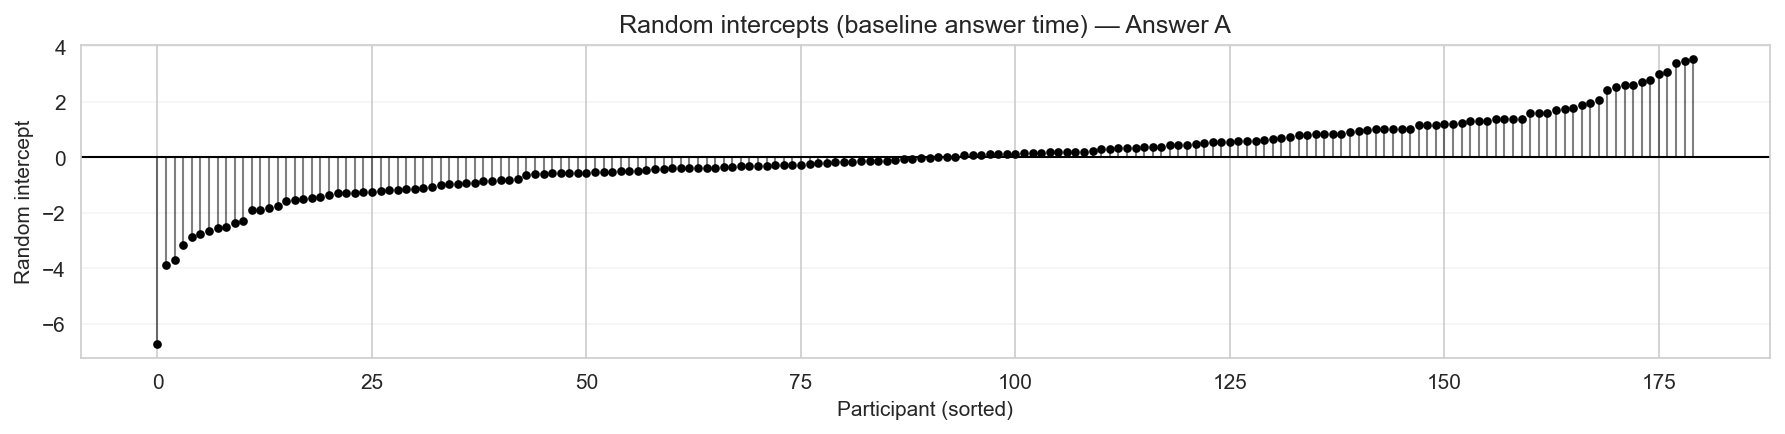

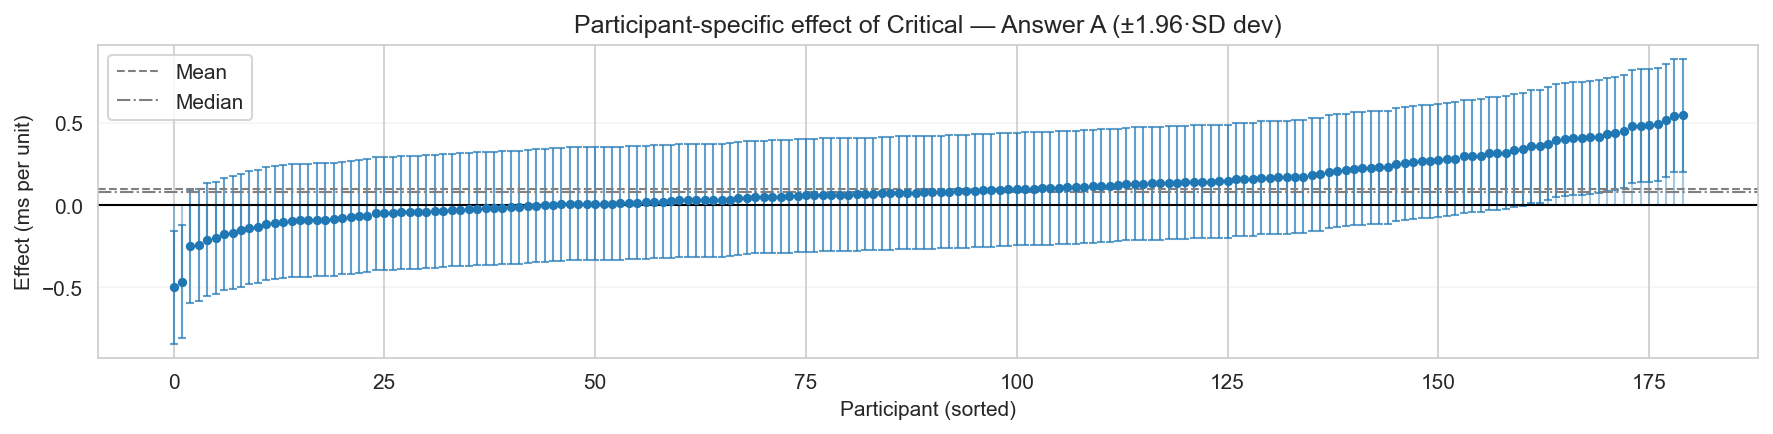

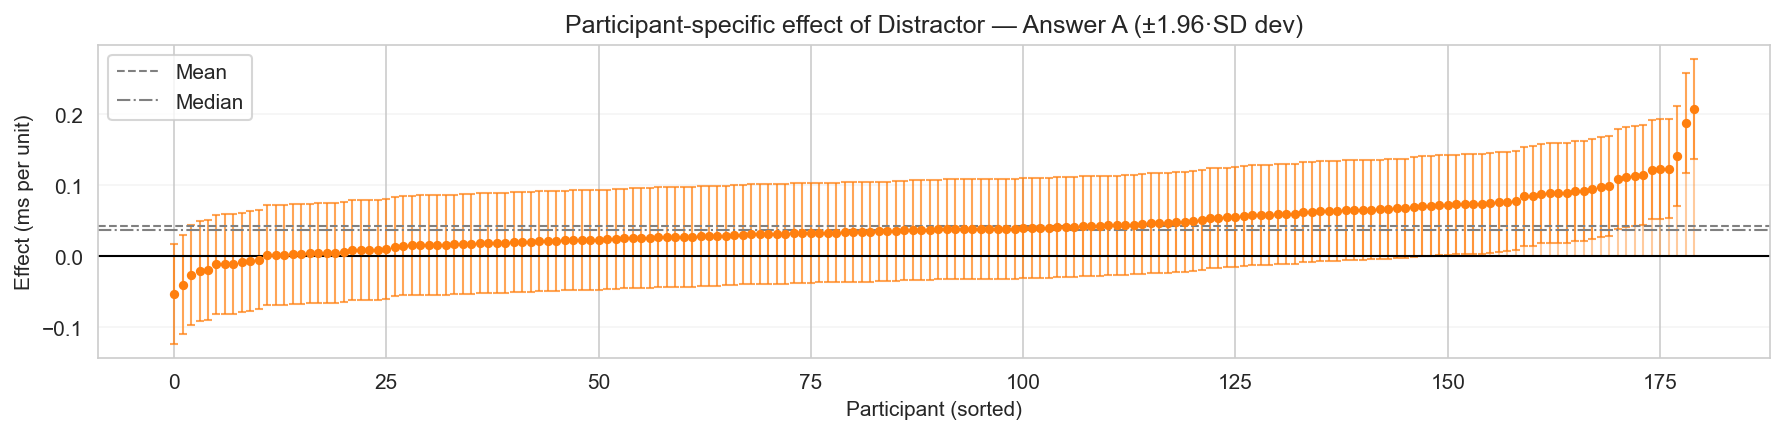

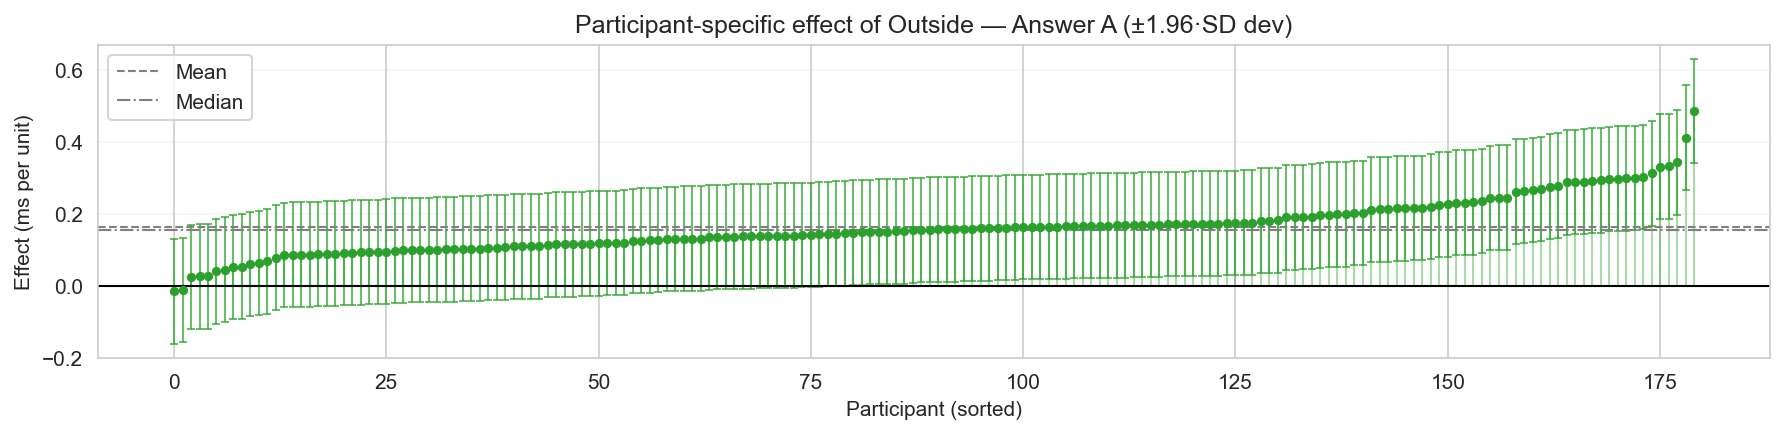


=== Answer B: fixed effects ===
critical     β=0.478 ± 0.228  p=6.987e-05 ***
distractor   β=0.125 ± 0.193  p=0.2035 
outside      β=-0.119 ± 0.279  p=0.403 


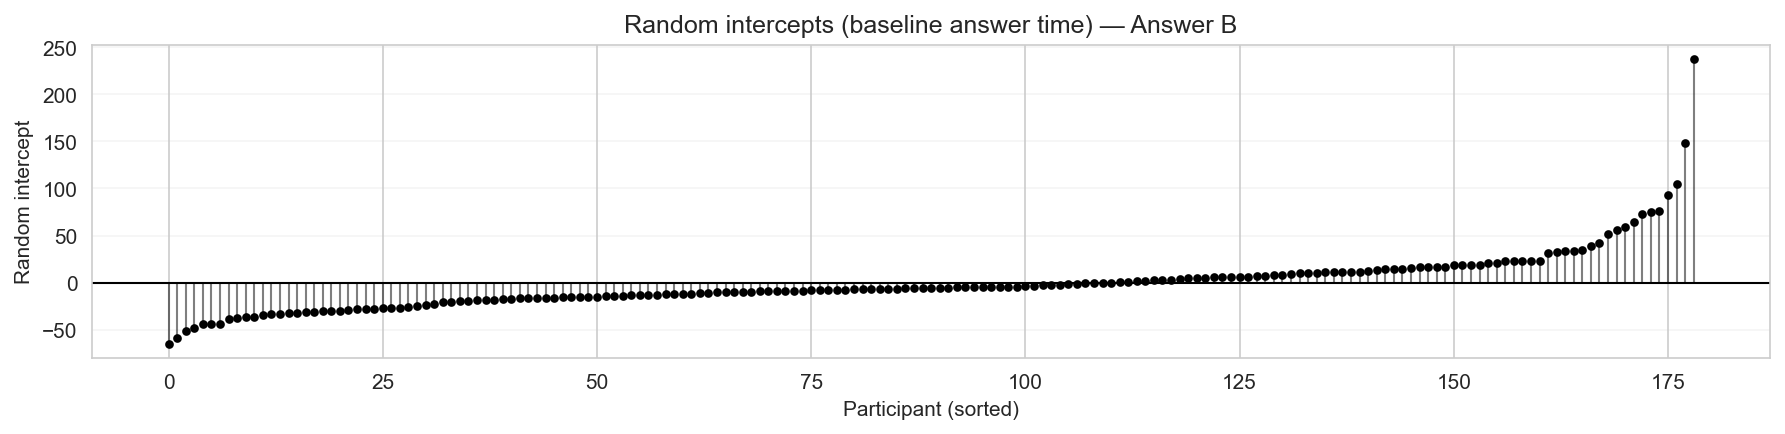

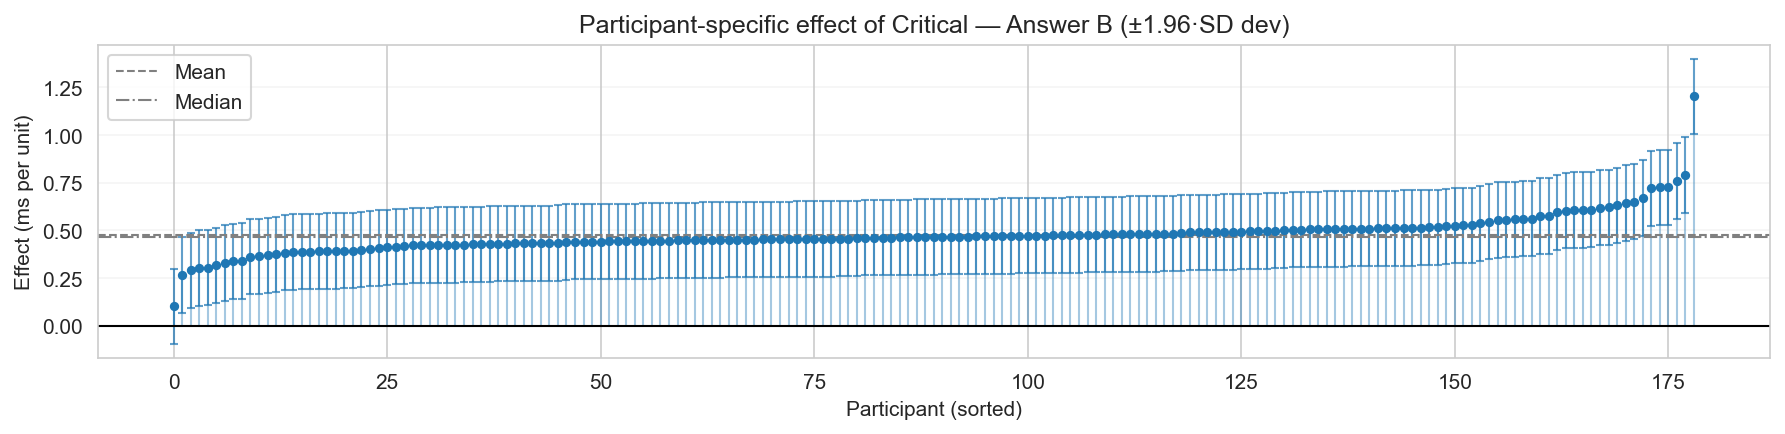

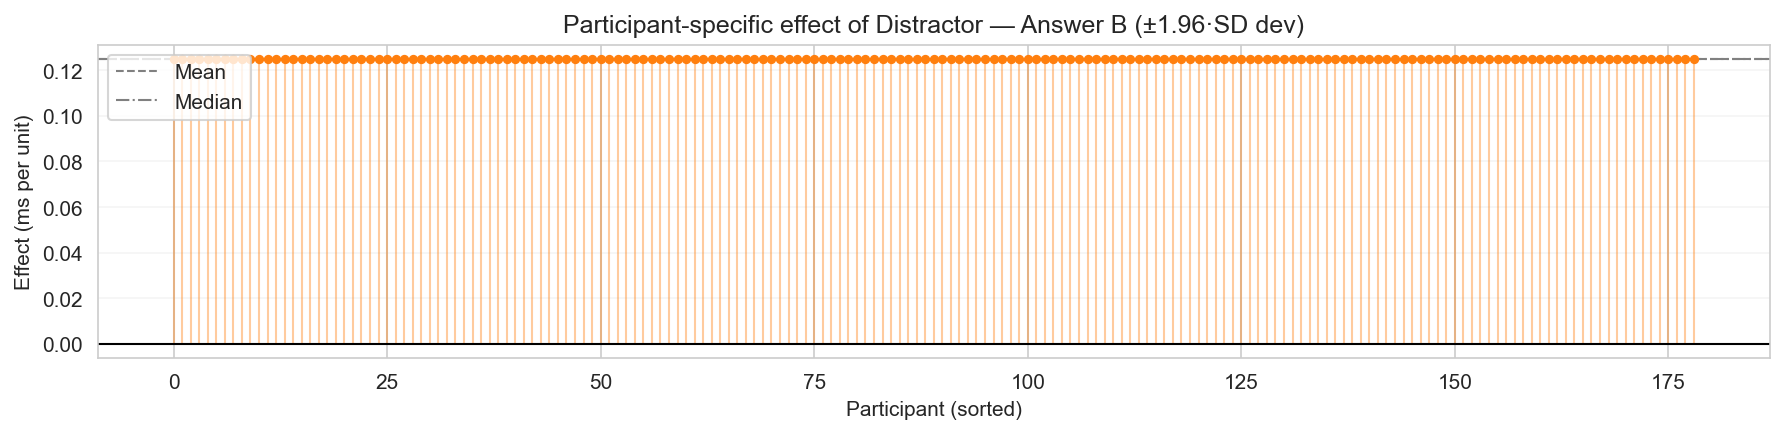

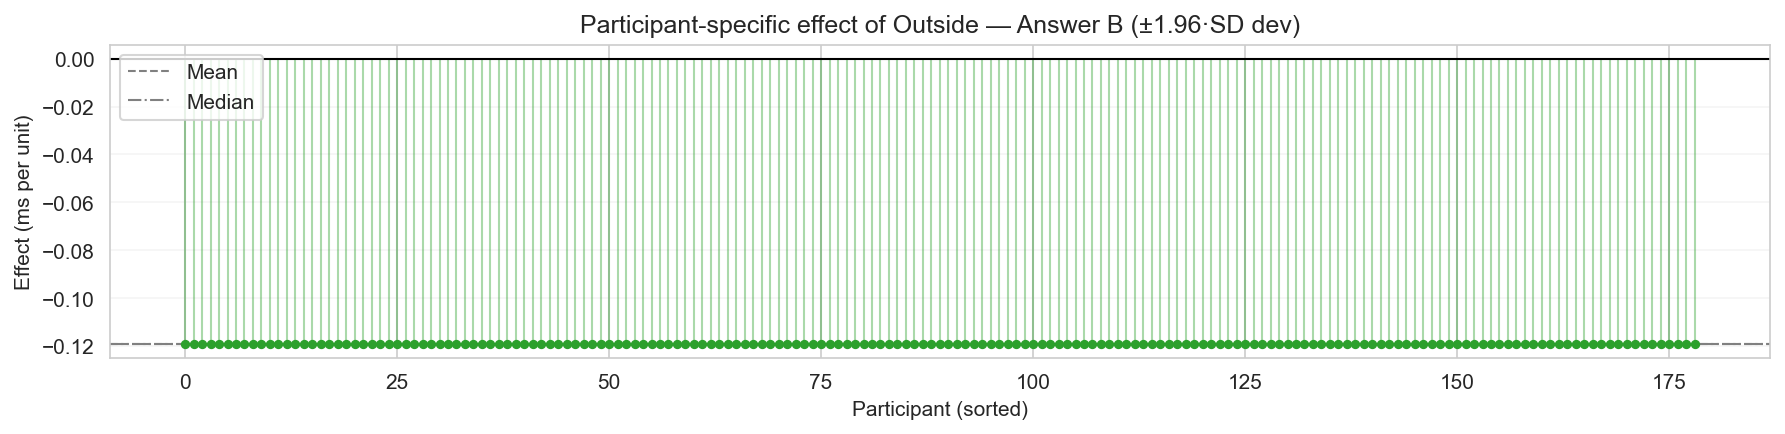


=== Answer C: fixed effects ===
critical     β=0.152 ± 0.258  p=0.2478 
distractor   β=-0.114 ± 0.174  p=0.199 
outside      β=0.565 ± 0.364  p=0.002557 **


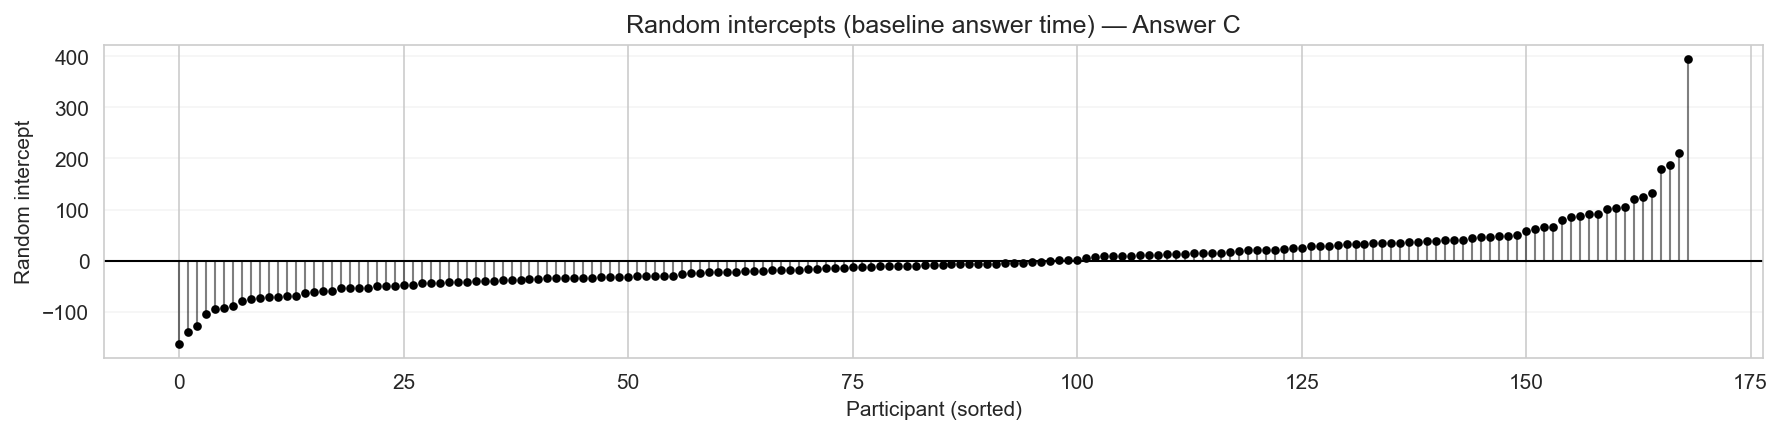

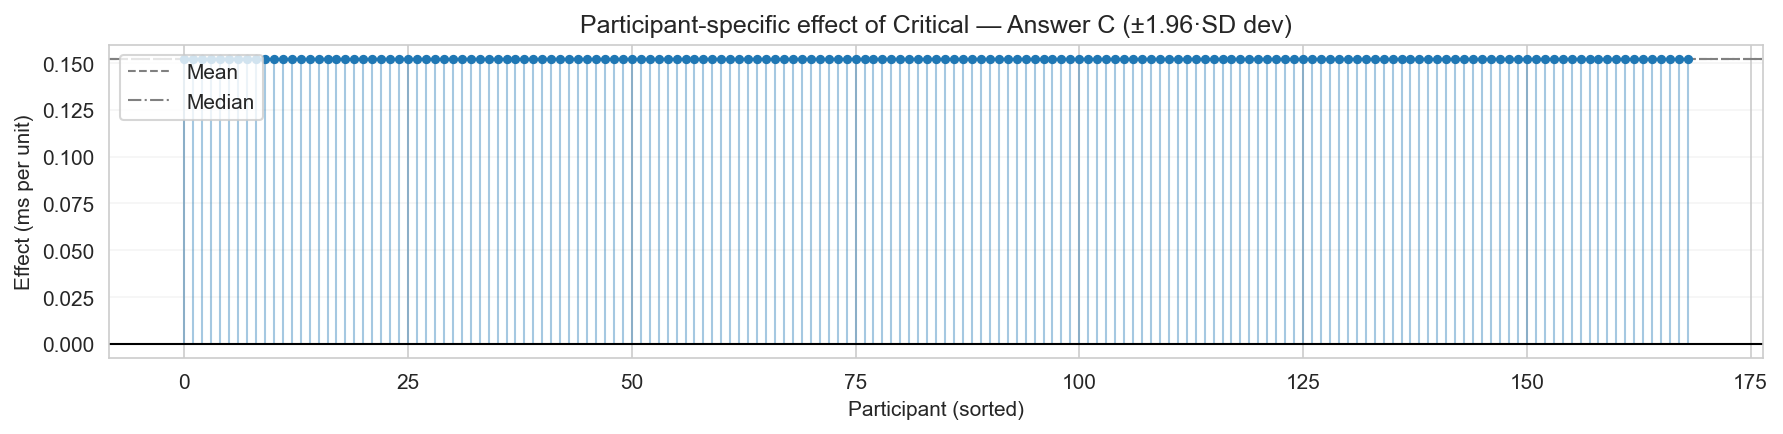

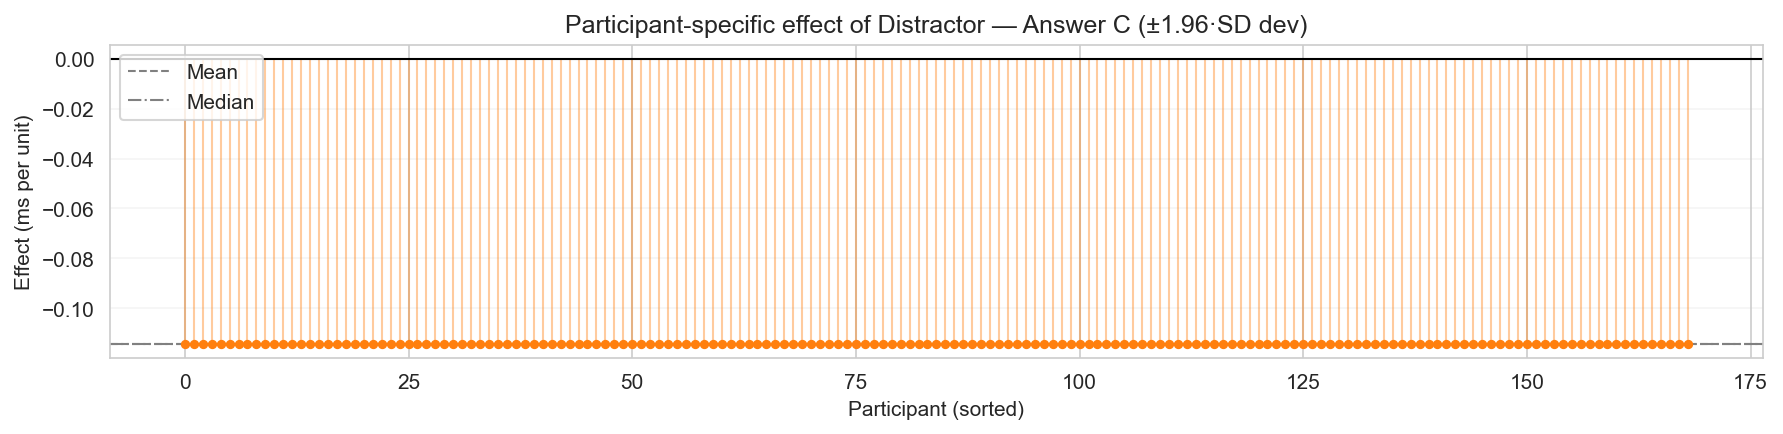

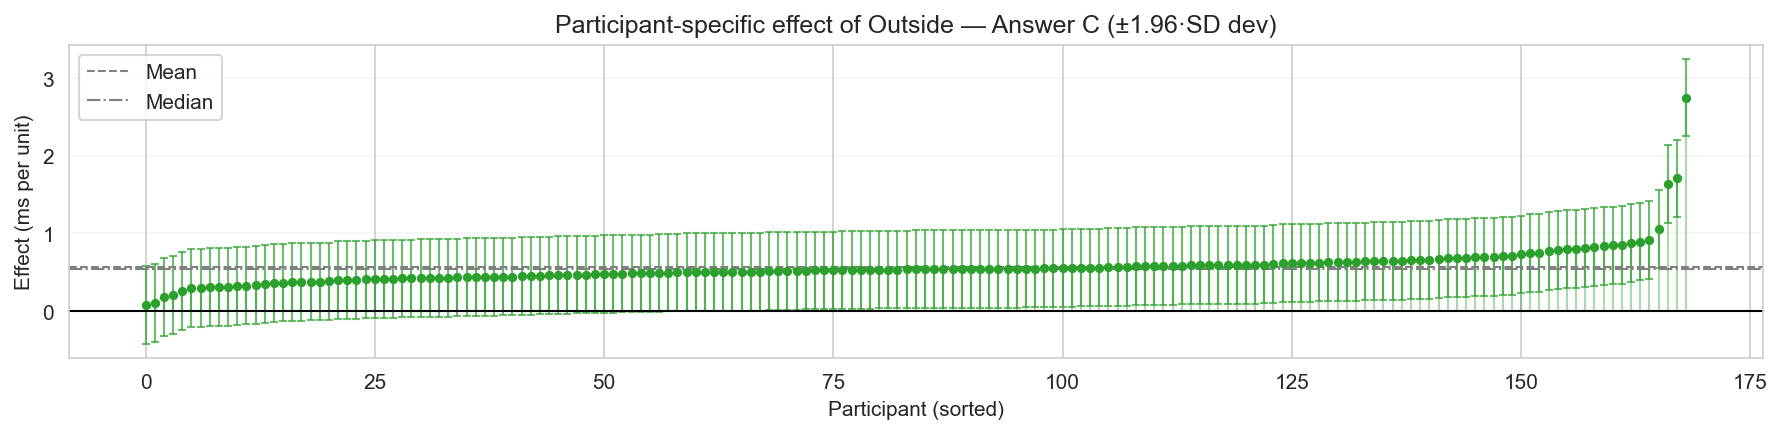


=== Answer D: fixed effects ===
critical     β=0.395 ± 0.436  p=0.07741 .
distractor   β=0.041 ± 0.281  p=0.777 
outside      β=0.616 ± 0.507  p=0.01801 *


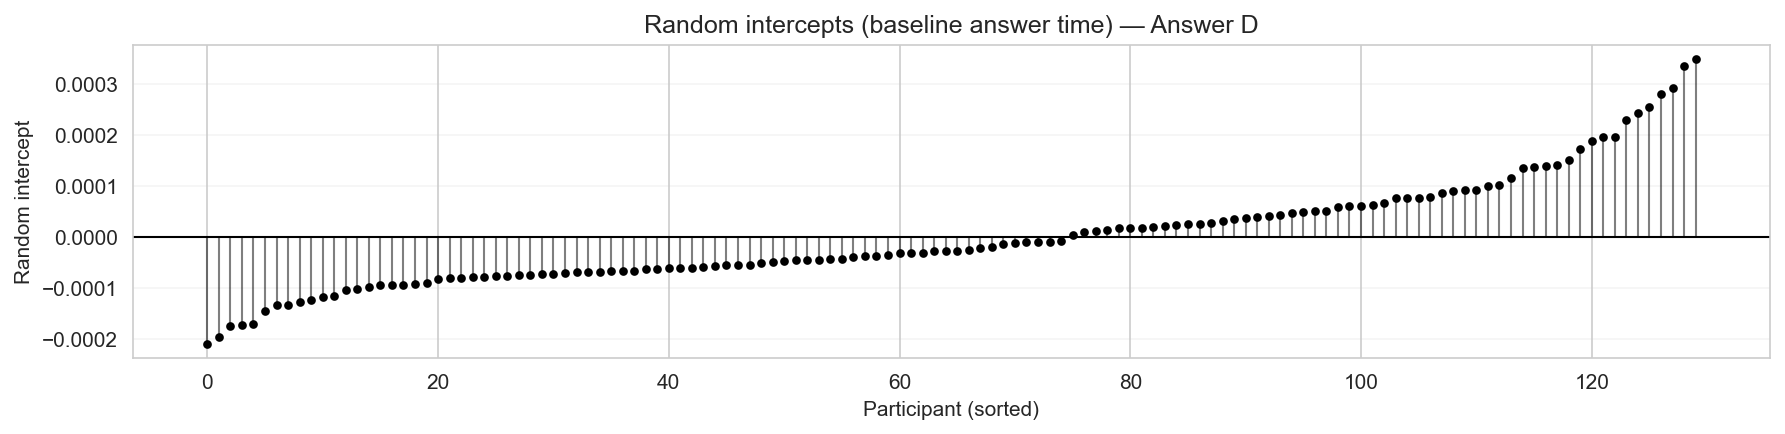

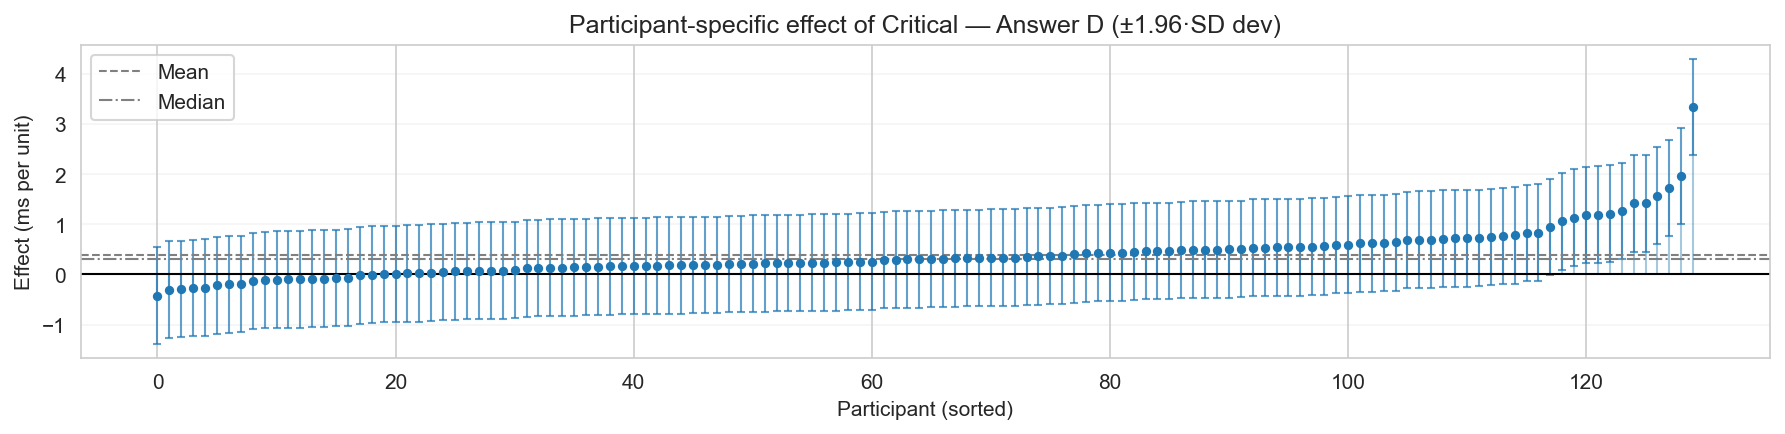

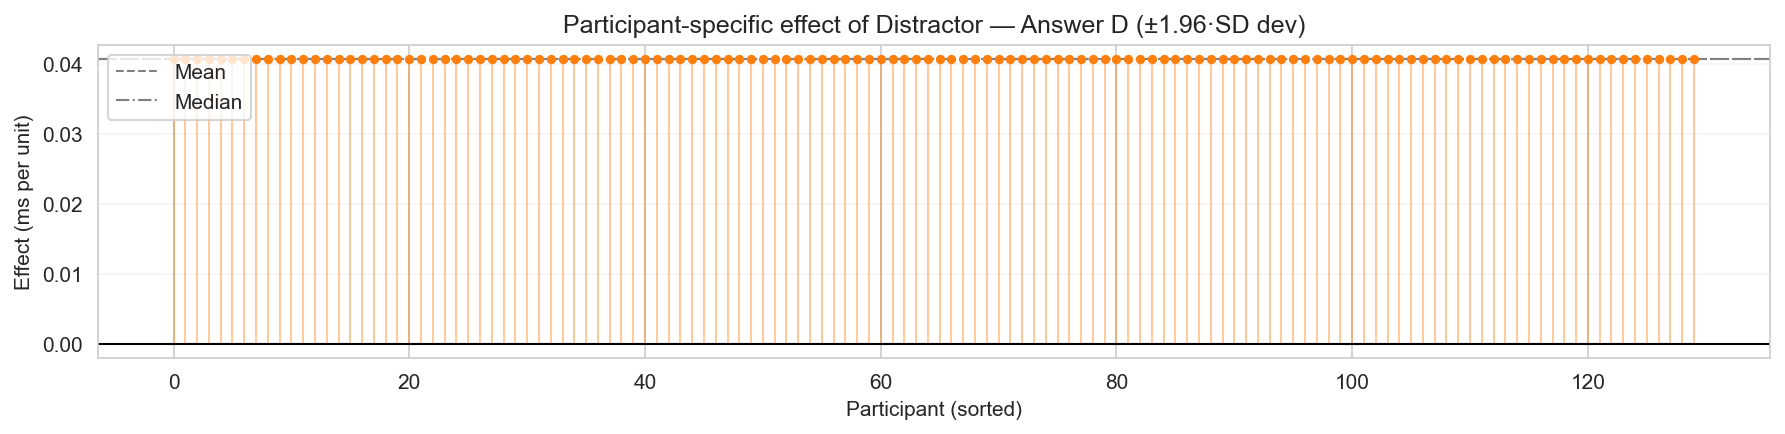

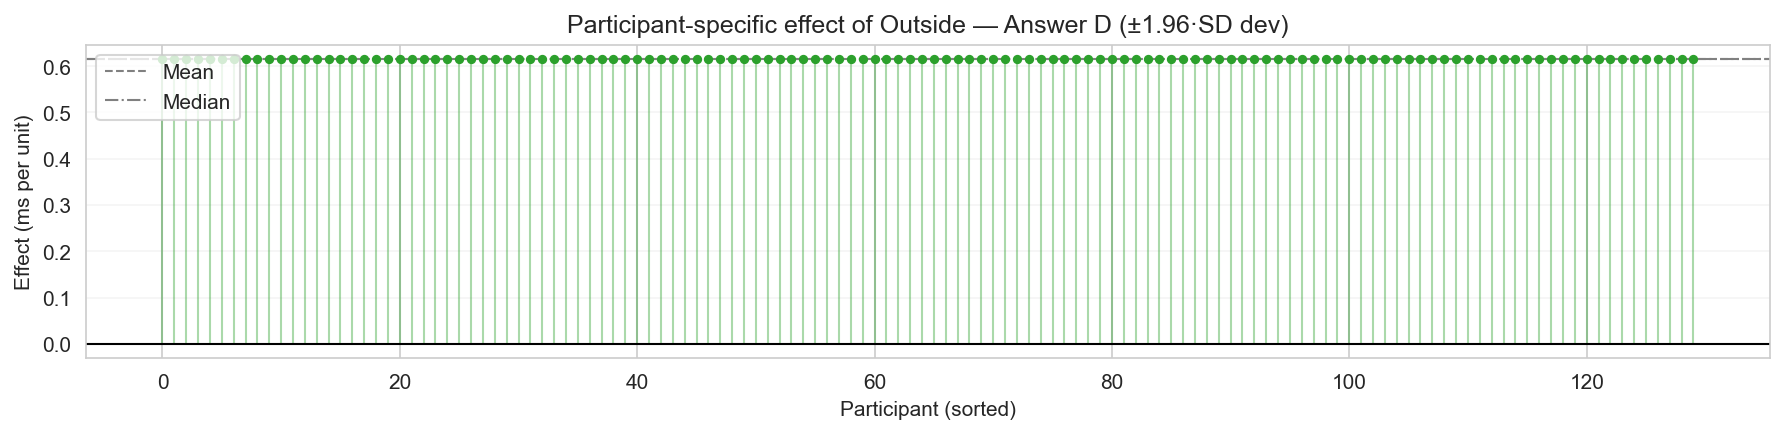

In [88]:
eff_Ag = plot_participant_effects(model_A_sloped_g, "Answer A")
eff_Bg = plot_participant_effects(model_B_sloped_g, "Answer B")
eff_Cg = plot_participant_effects(model_C_sloped_g, "Answer C")
eff_Dg= plot_participant_effects(model_D_sloped_g, "Answer D")


=== Answer A: fixed effects ===
critical     β=0.108 ± 0.052  p=5.644e-05 ***
distractor   β=0.030 ± 0.047  p=0.2125 
outside      β=0.104 ± 0.073  p=0.005668 **


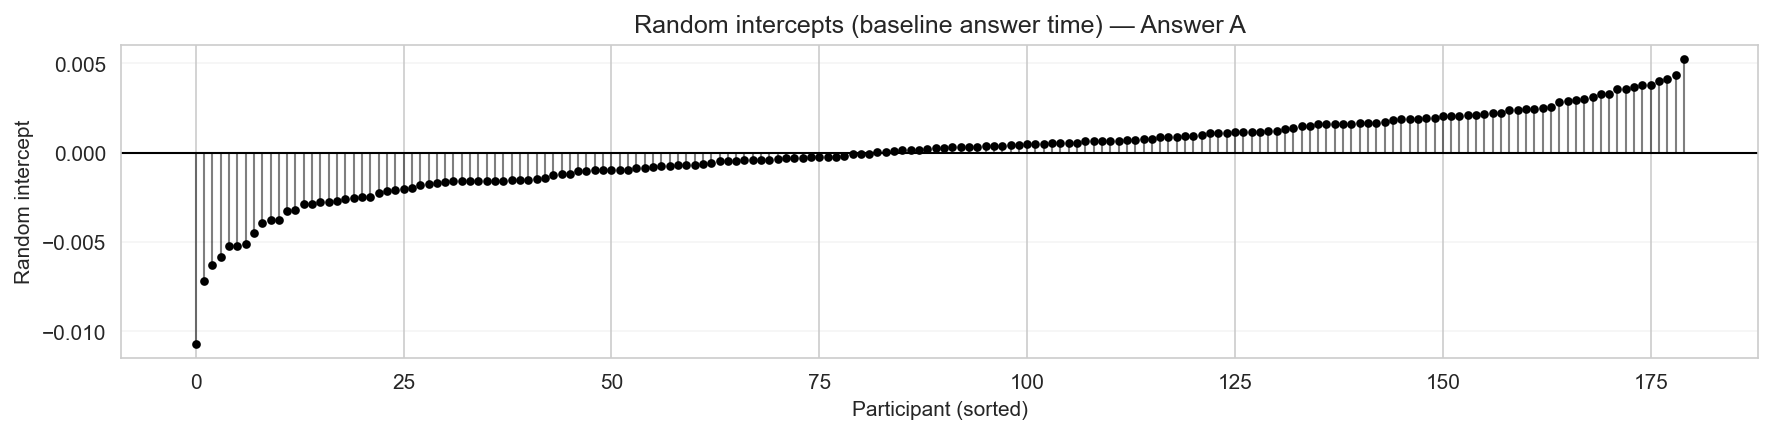

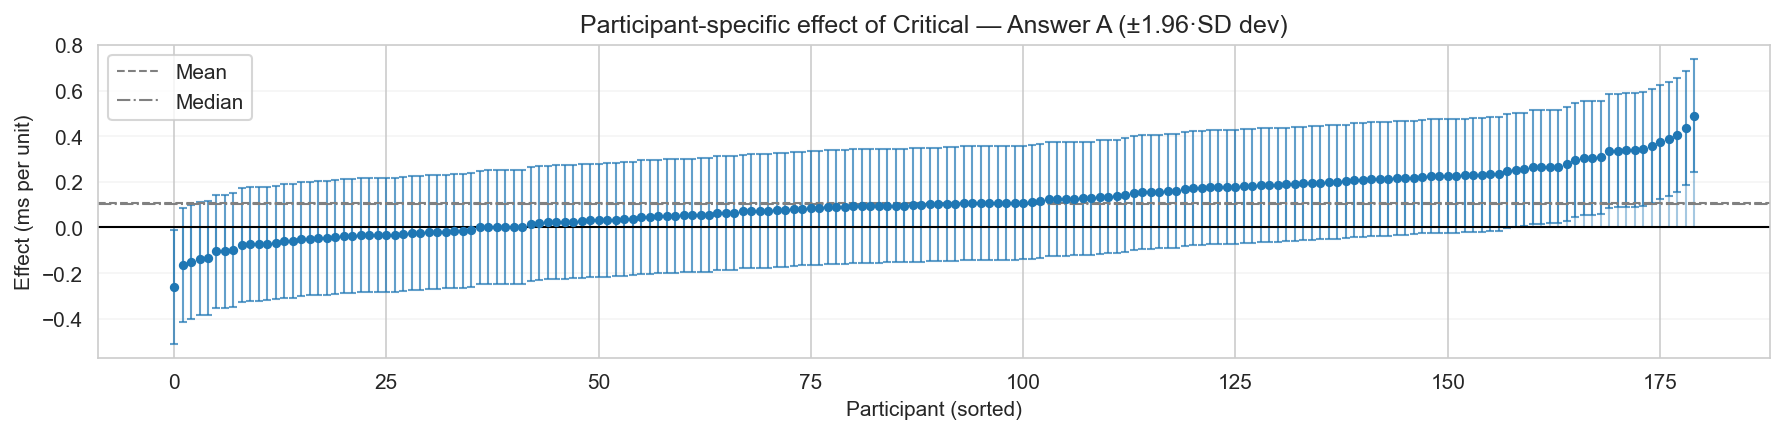

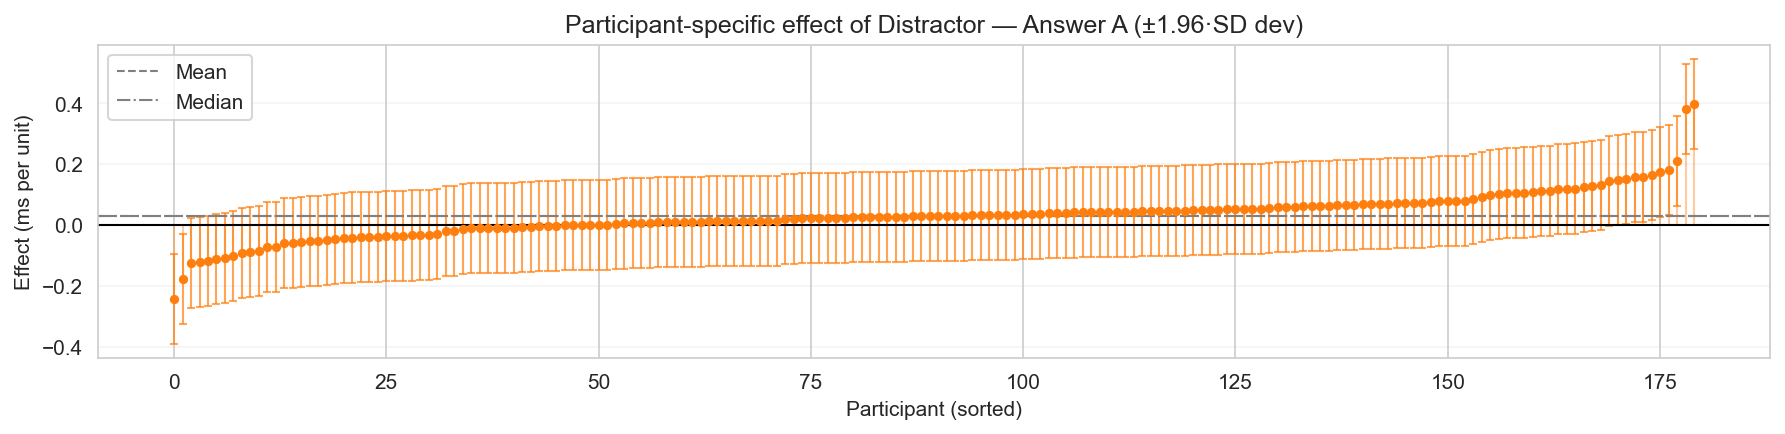

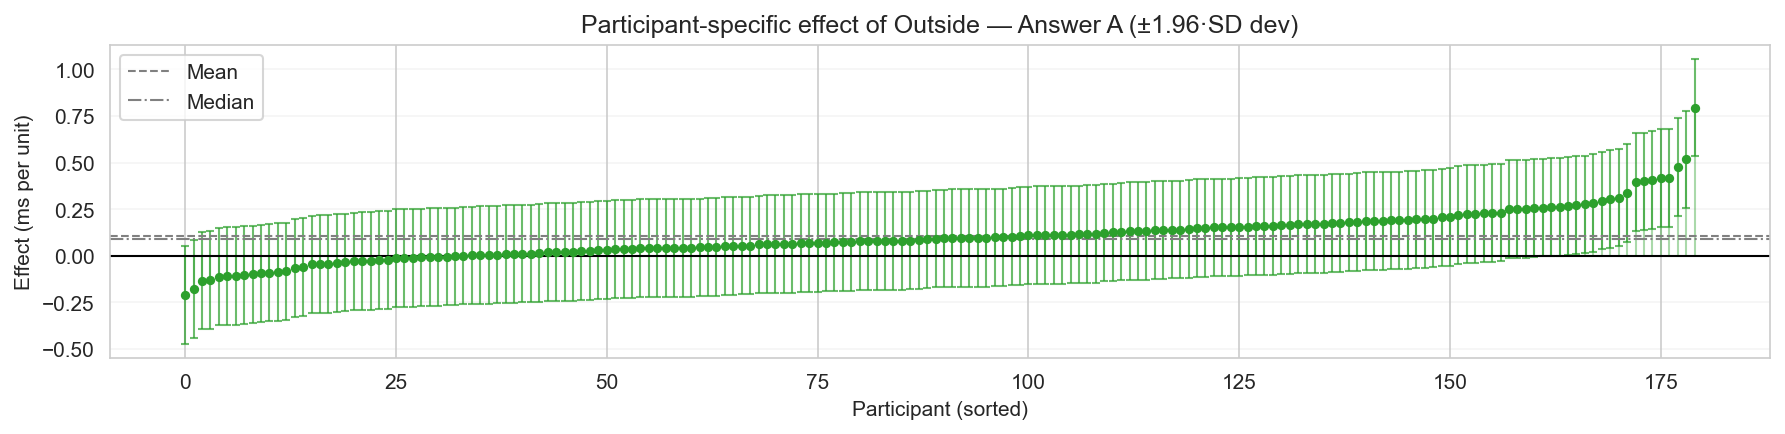


=== Answer B: fixed effects ===
critical     β=0.106 ± 0.043  p=2.627e-06 ***
distractor   β=0.002 ± 0.034  p=0.9004 
outside      β=0.157 ± 0.062  p=3.213e-06 ***


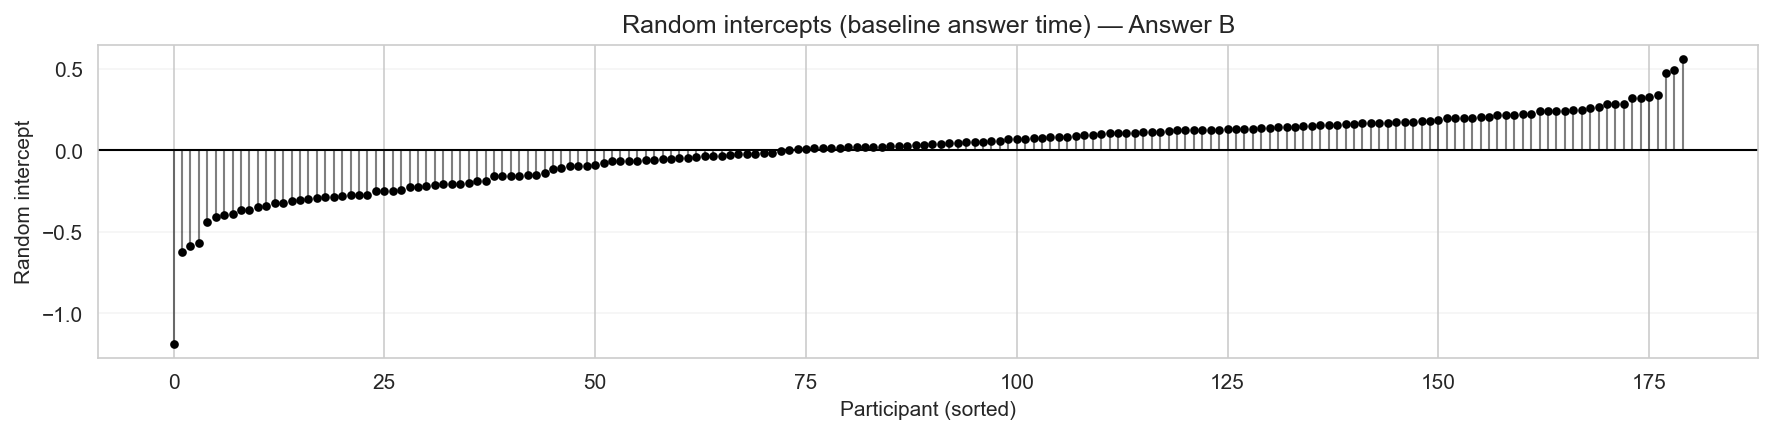

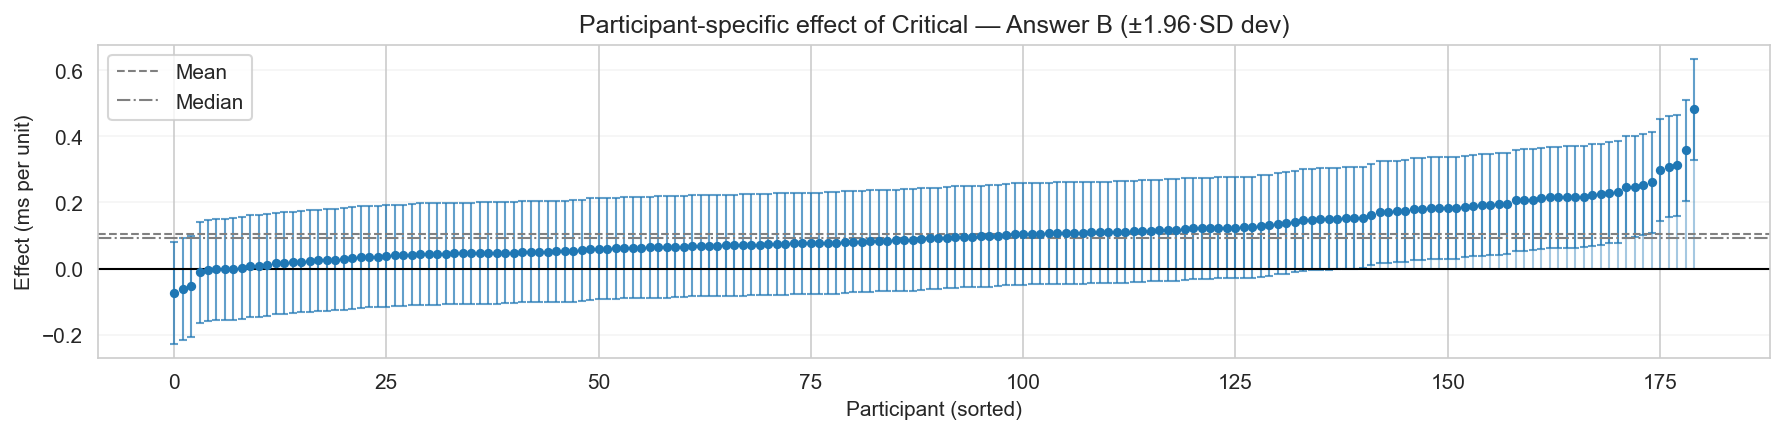

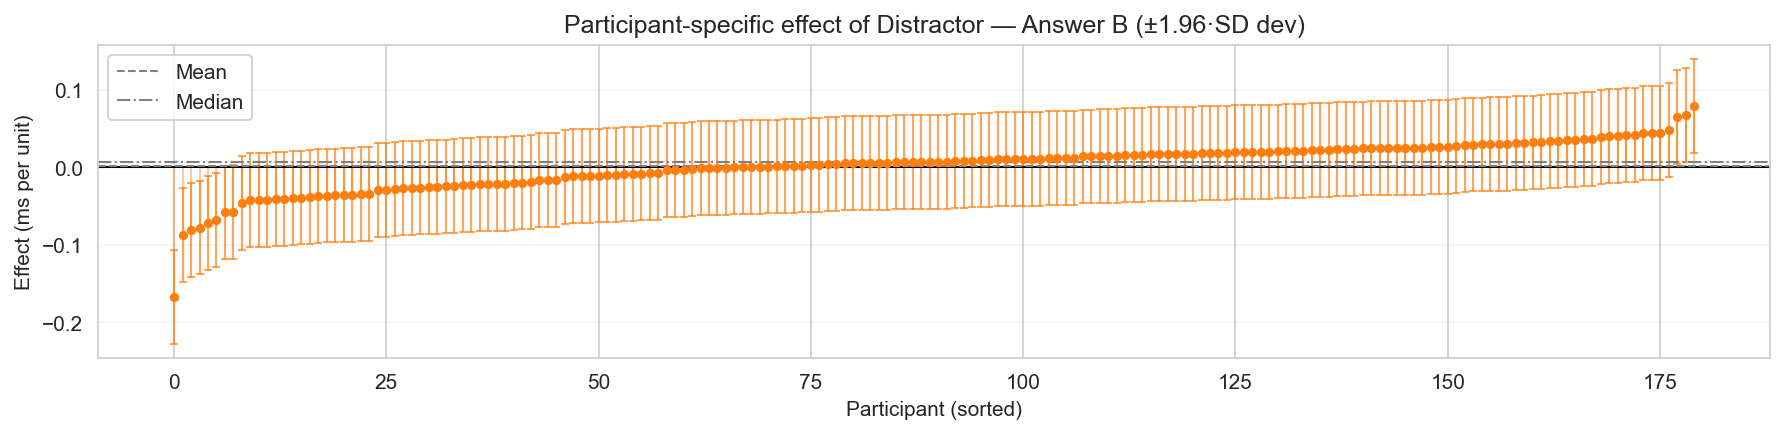

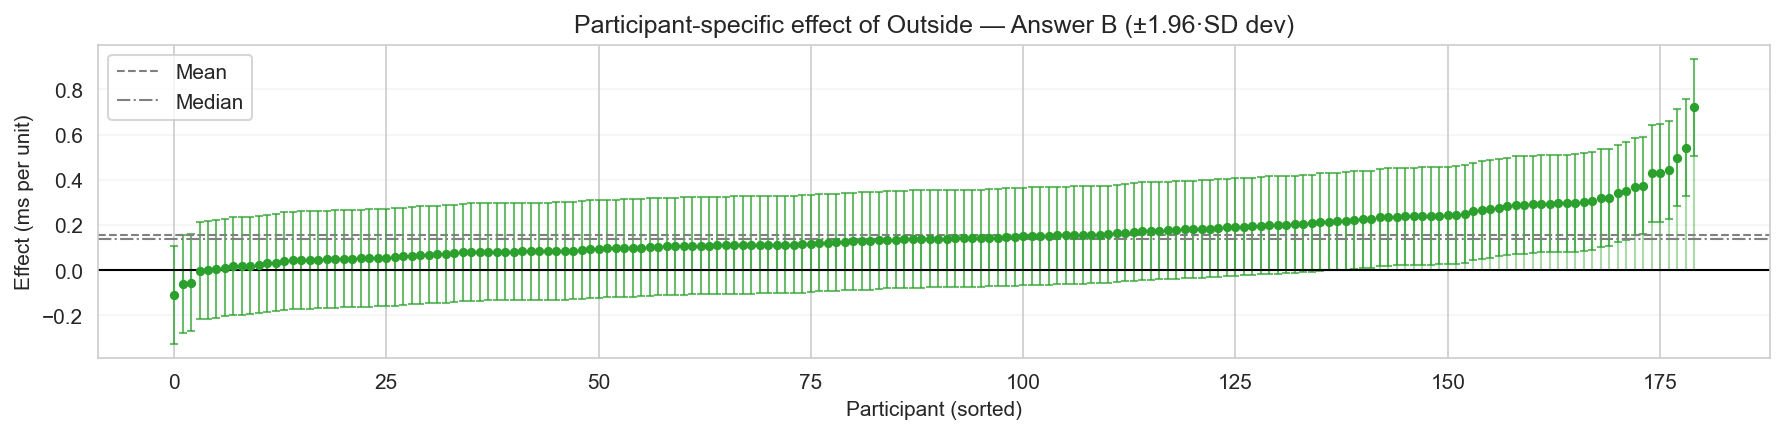


=== Answer C: fixed effects ===
critical     β=0.041 ± 0.032  p=0.01296 *
distractor   β=0.021 ± 0.041  p=0.3129 
outside      β=0.208 ± 0.061  p=3.342e-10 ***


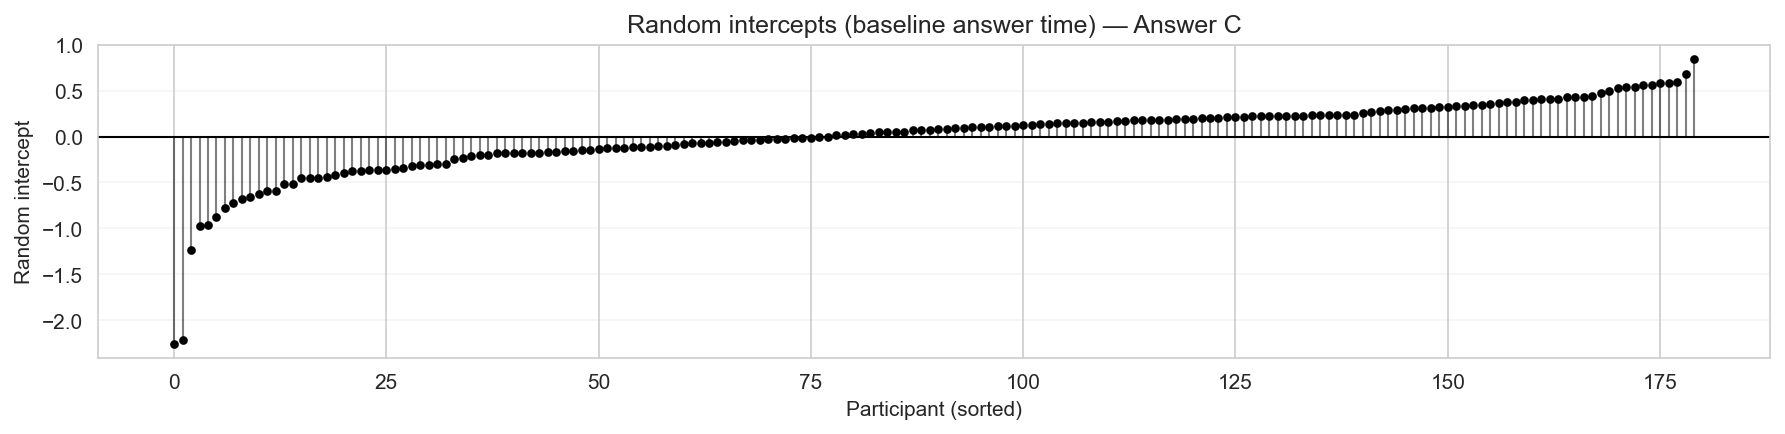

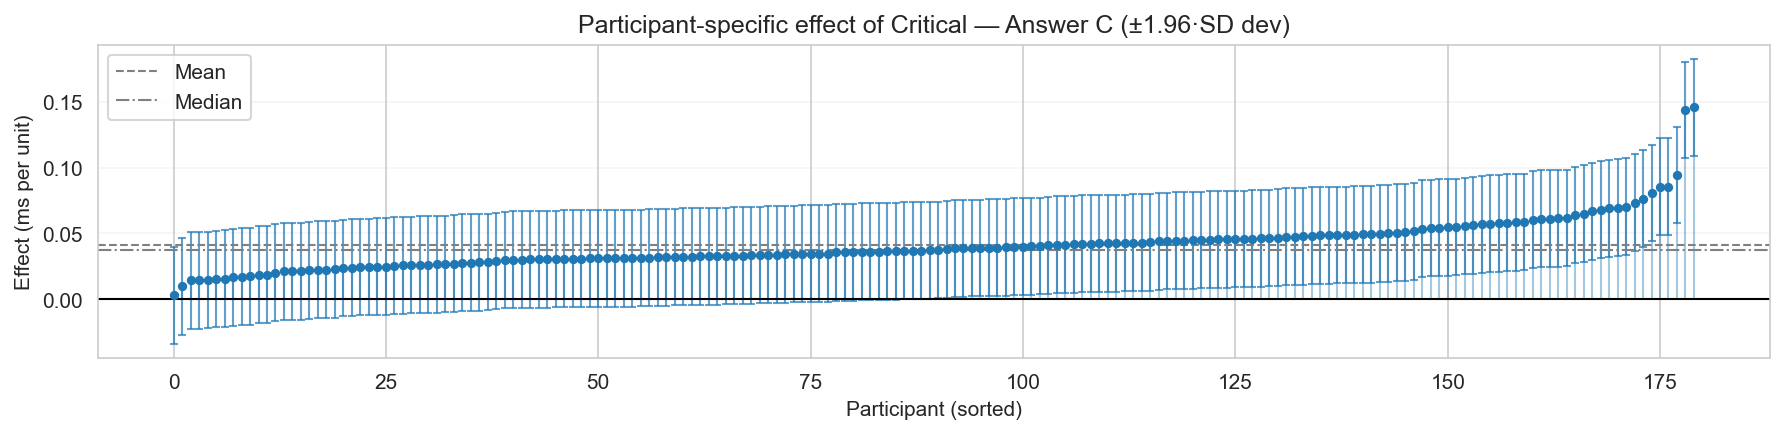

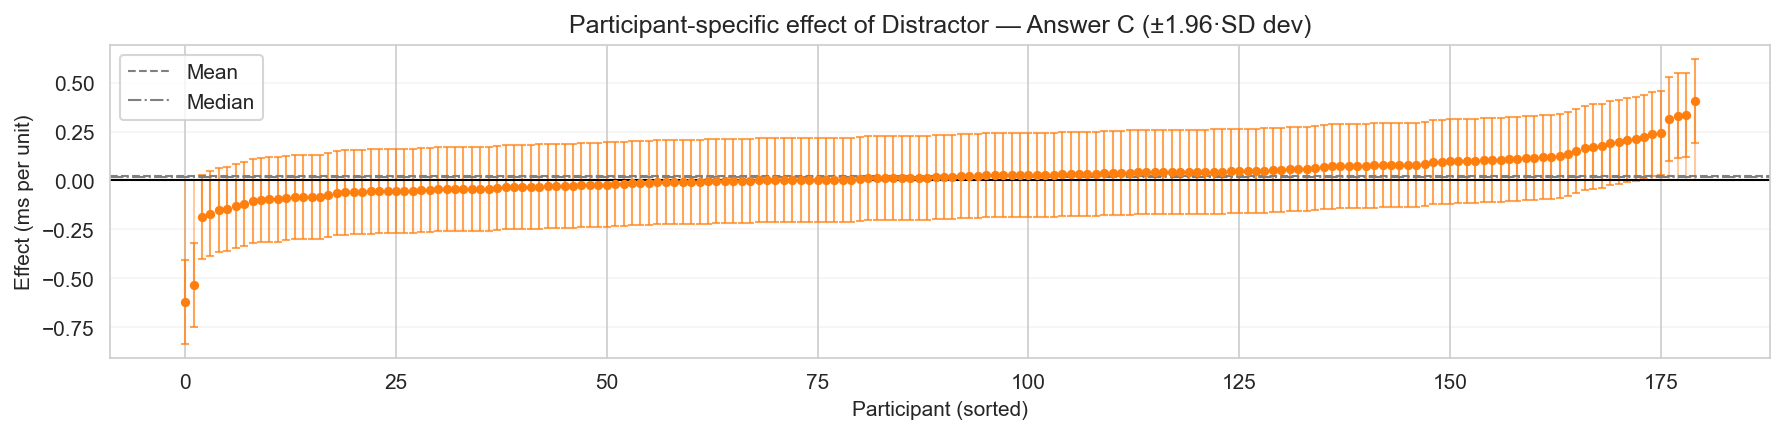

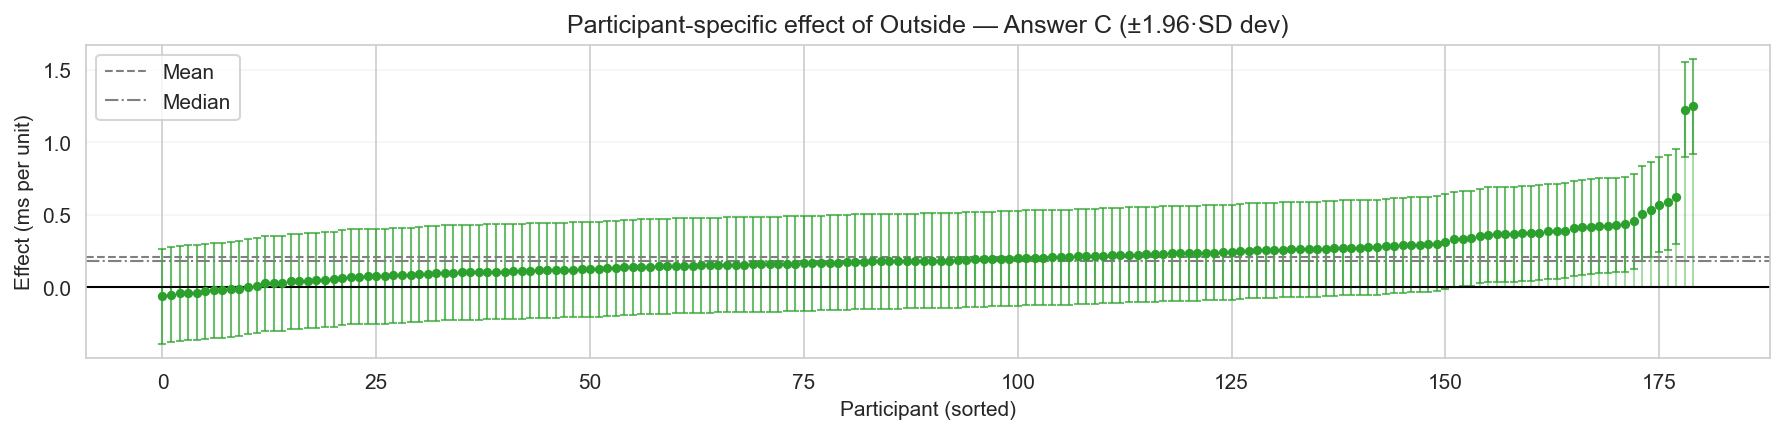


=== Answer D: fixed effects ===
critical     β=0.012 ± 0.031  p=0.4525 
distractor   β=0.011 ± 0.028  p=0.4307 
outside      β=0.152 ± 0.050  p=1.809e-08 ***


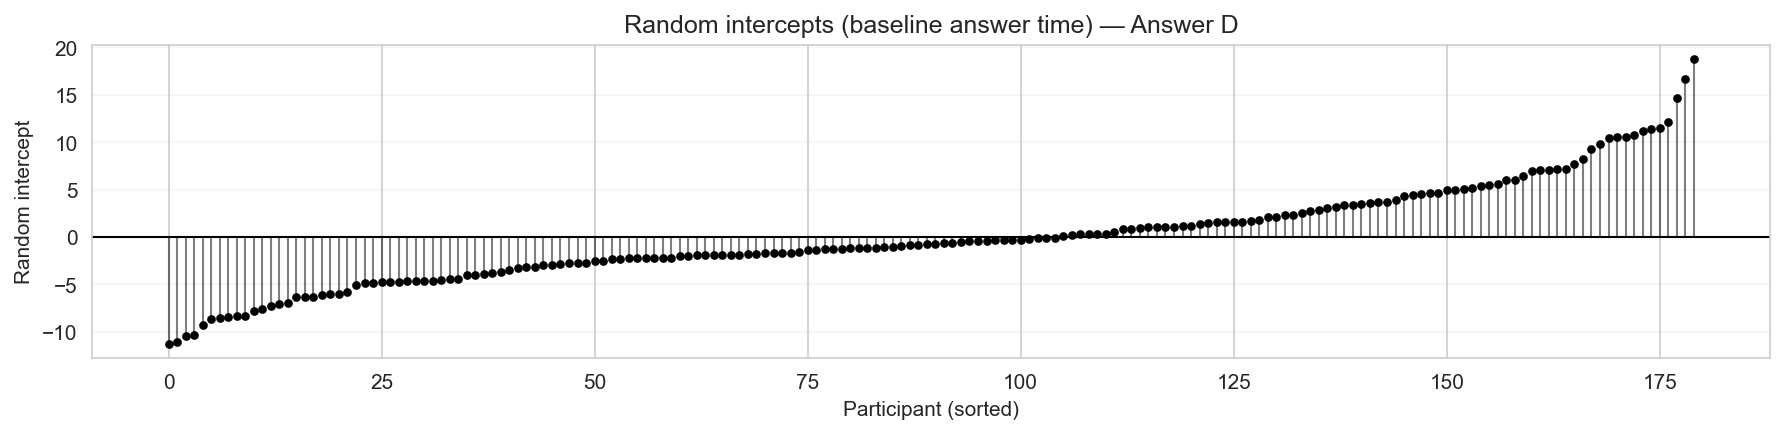

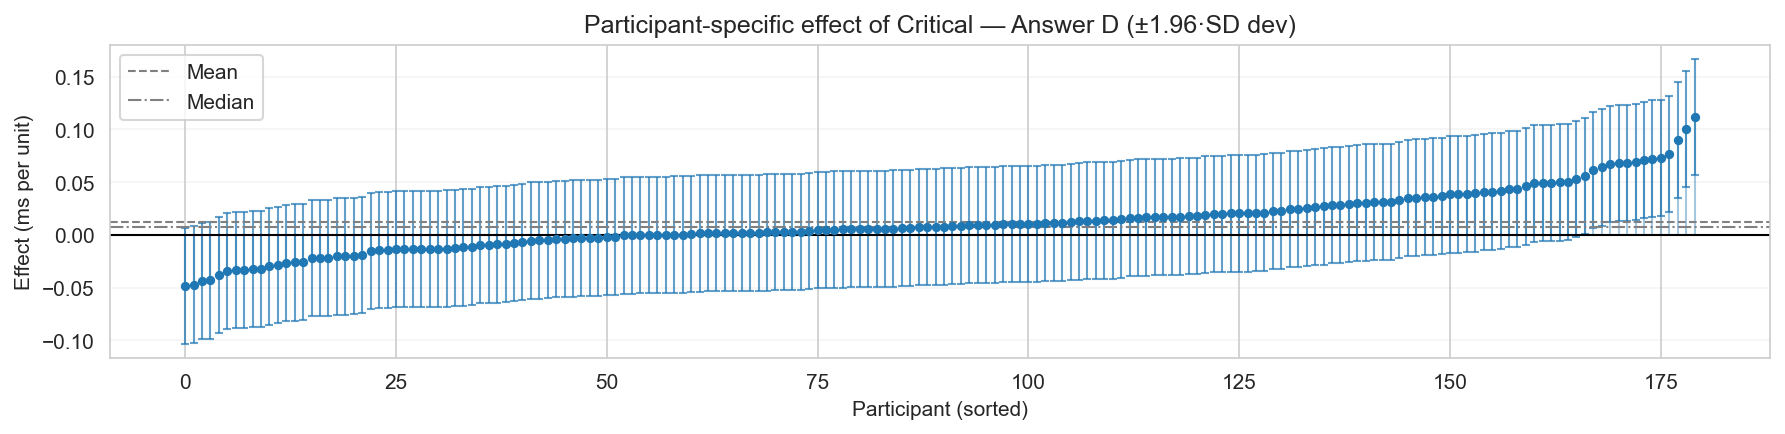

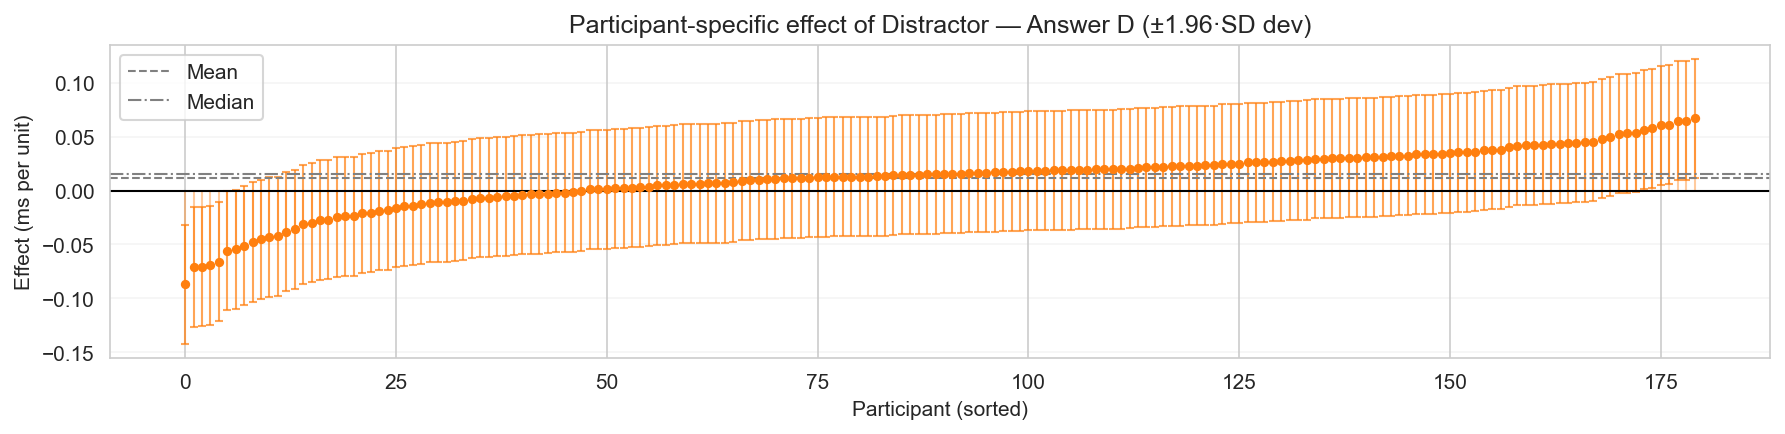

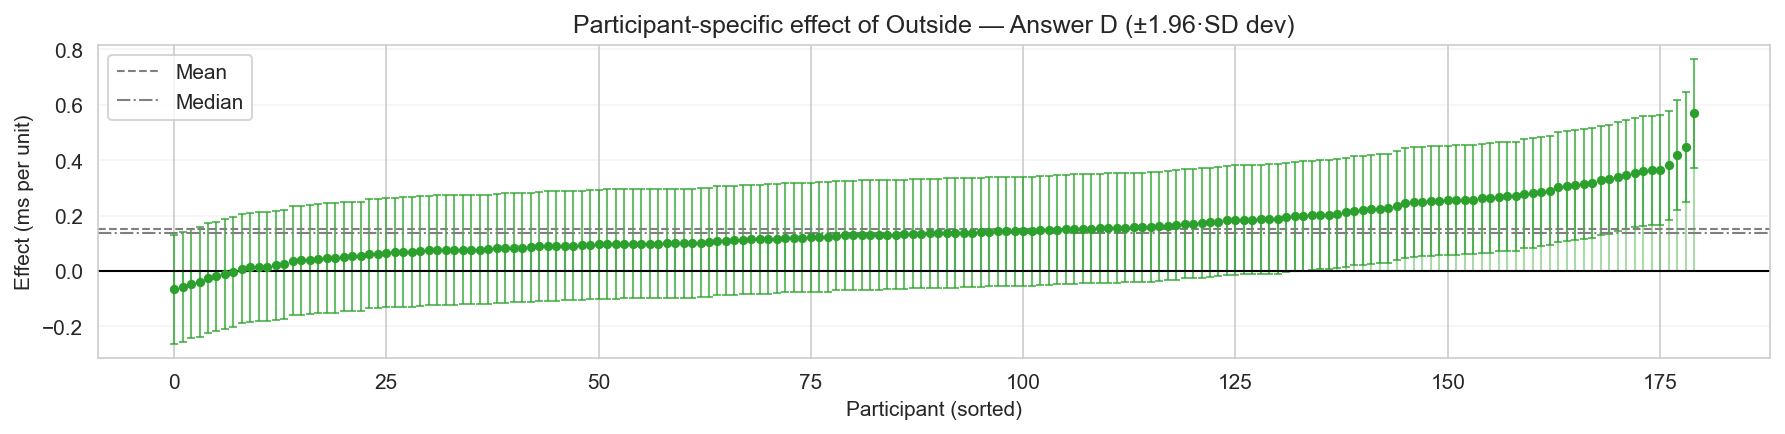

In [89]:
eff_A_all = plot_participant_effects(model_A_sloped_h_all, "Answer A")
eff_B_all = plot_participant_effects(model_B_sloped_h_all, "Answer B")
eff_C_all = plot_participant_effects(model_C_sloped_h_all, "Answer C")
eff_D_all = plot_participant_effects(model_D_sloped_h_all, "Answer D")


=== Answer A: fixed effects ===
critical     β=0.109 ± 0.060  p=0.0004999 ***
distractor   β=0.041 ± 0.037  p=0.0286 *
outside      β=0.169 ± 0.067  p=1.346e-06 ***


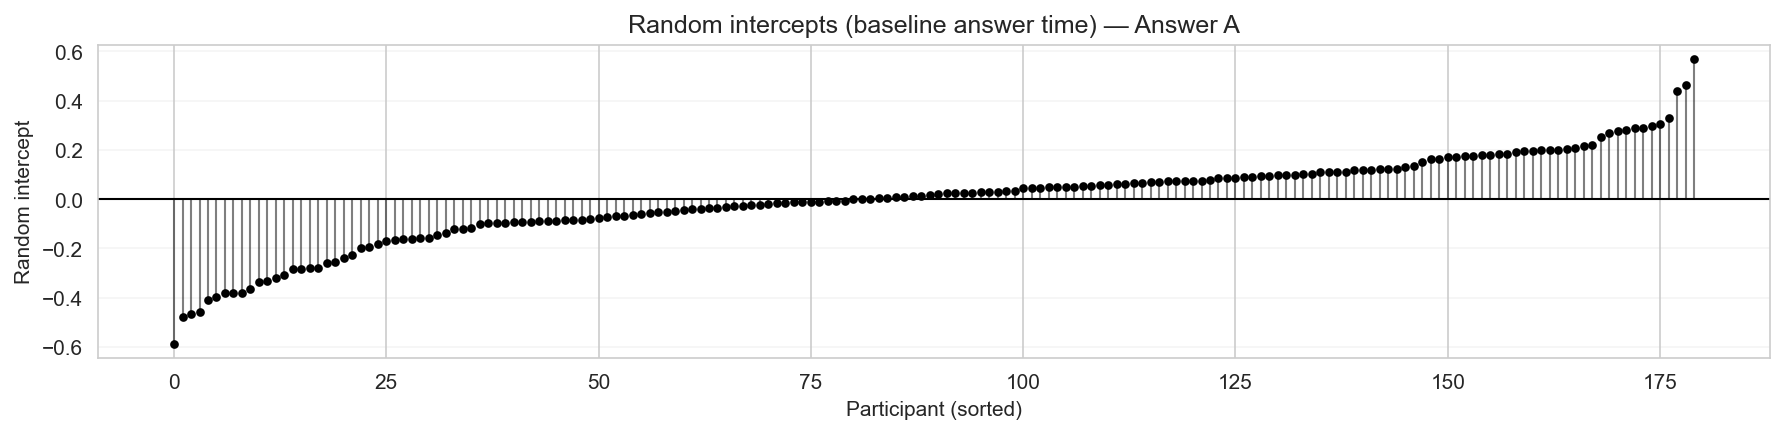

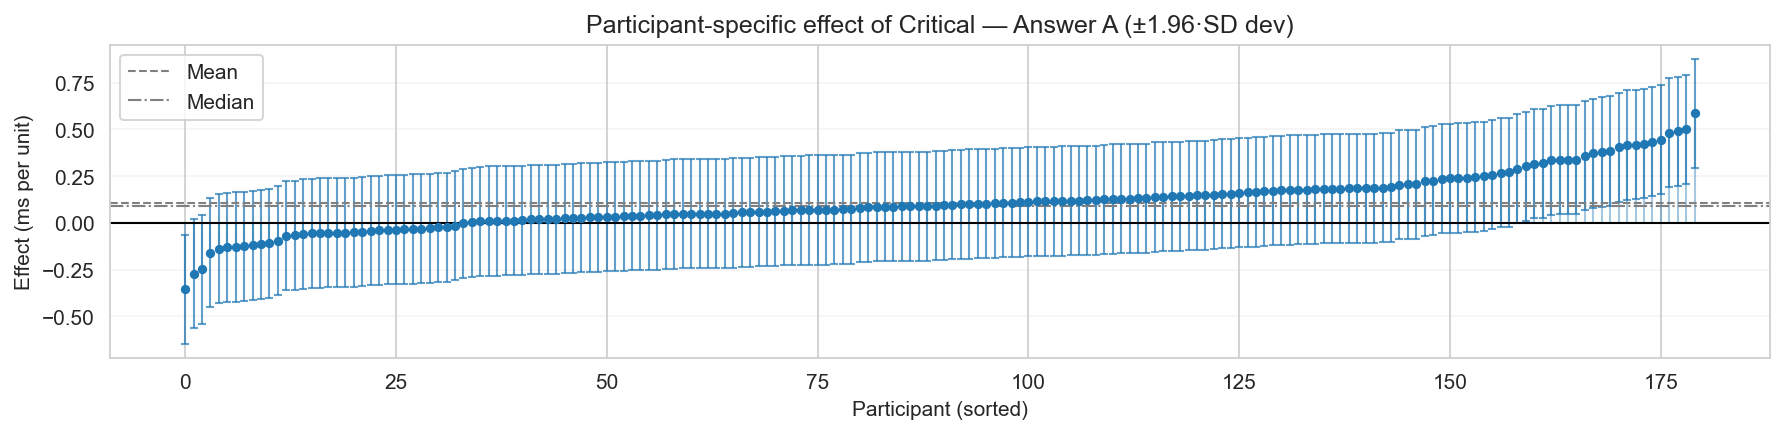

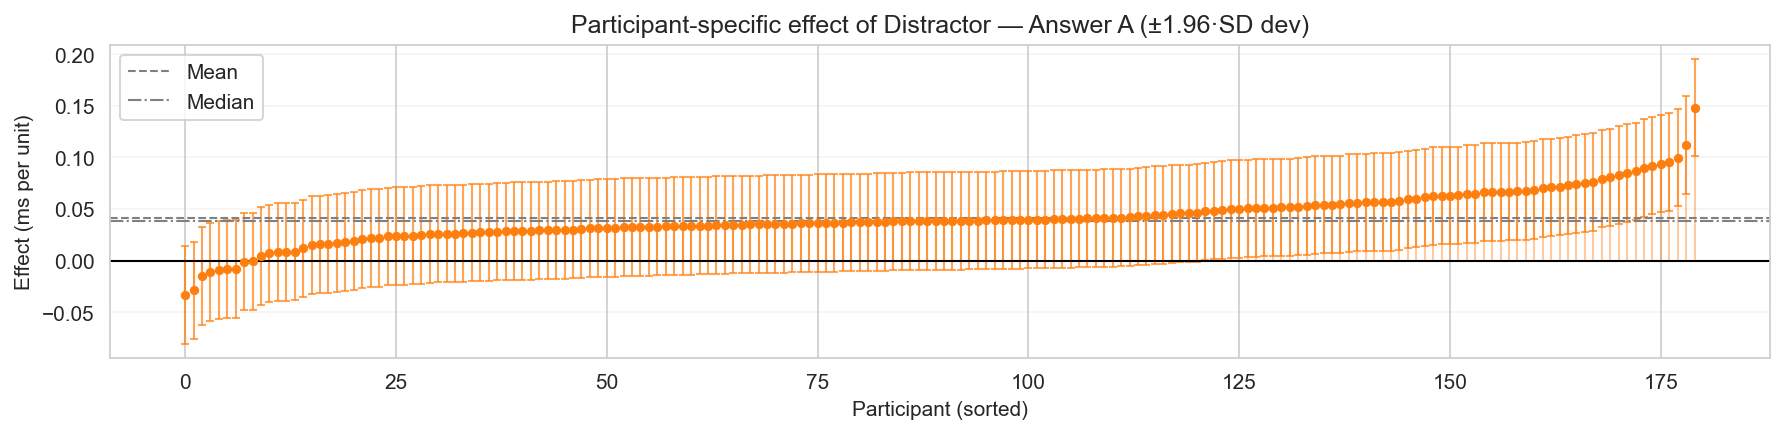

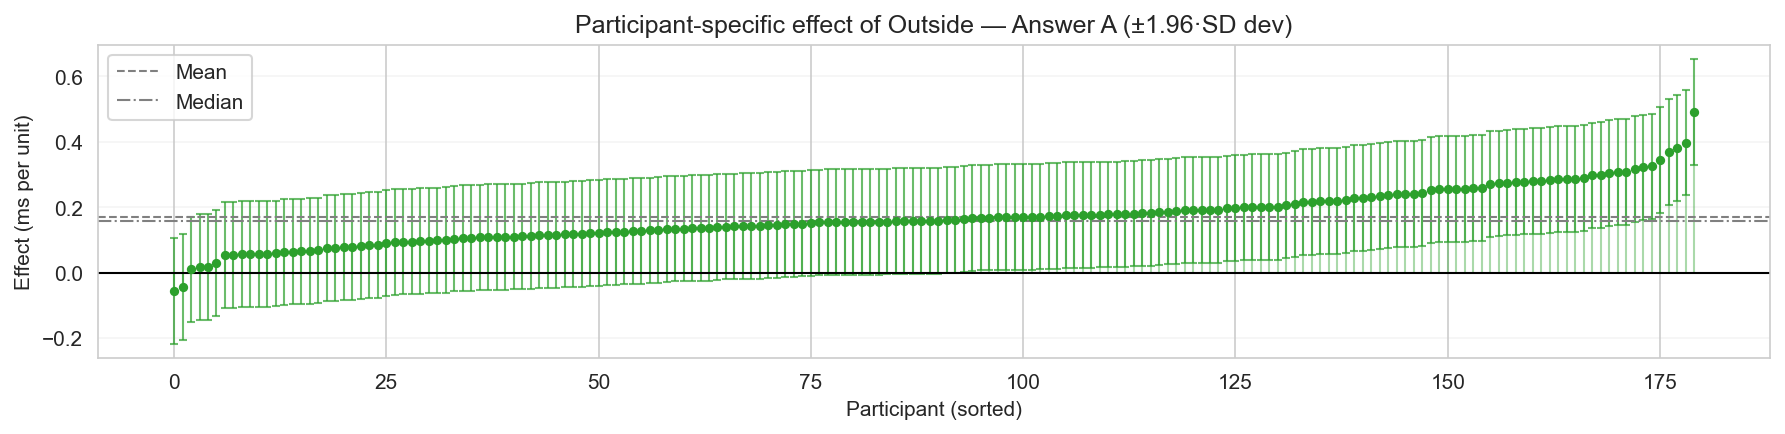


=== Answer B: fixed effects ===
critical     β=0.114 ± 0.060  p=0.0002162 ***
distractor   β=0.010 ± 0.035  p=0.5808 
outside      β=0.128 ± 0.056  p=1.034e-05 ***


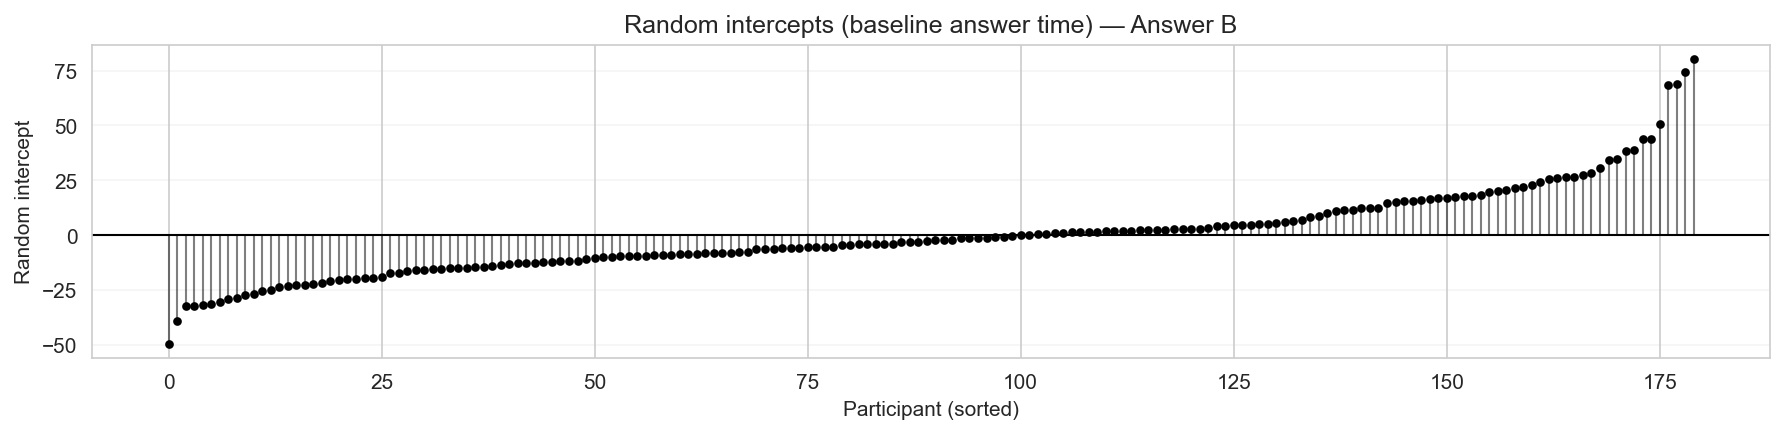

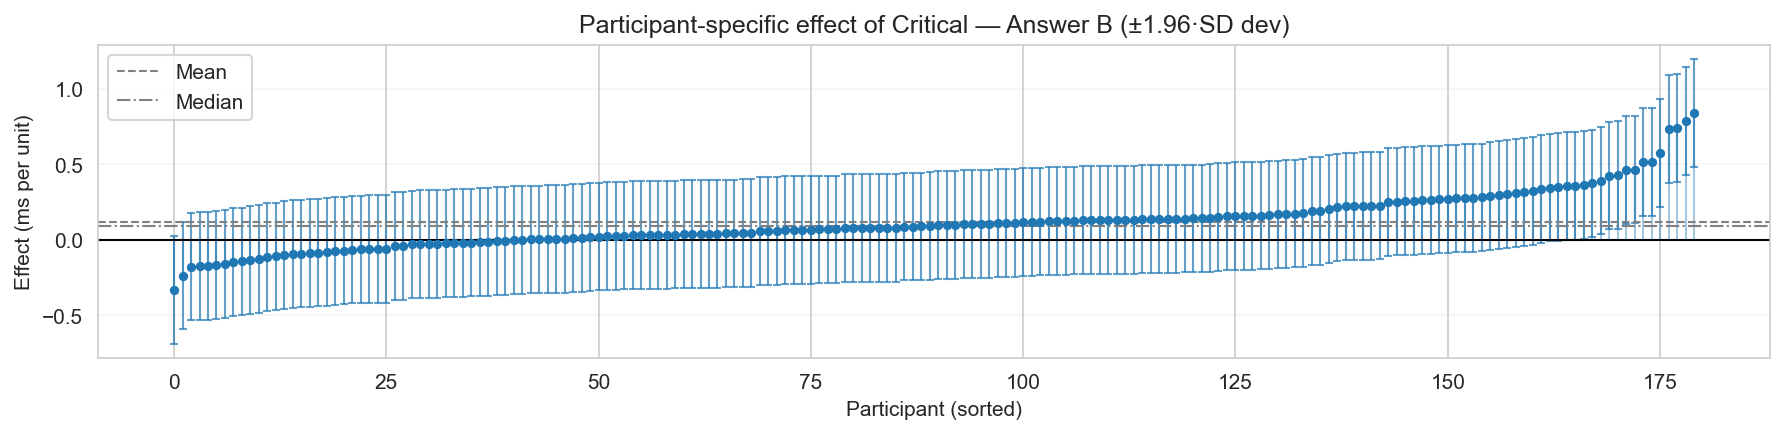

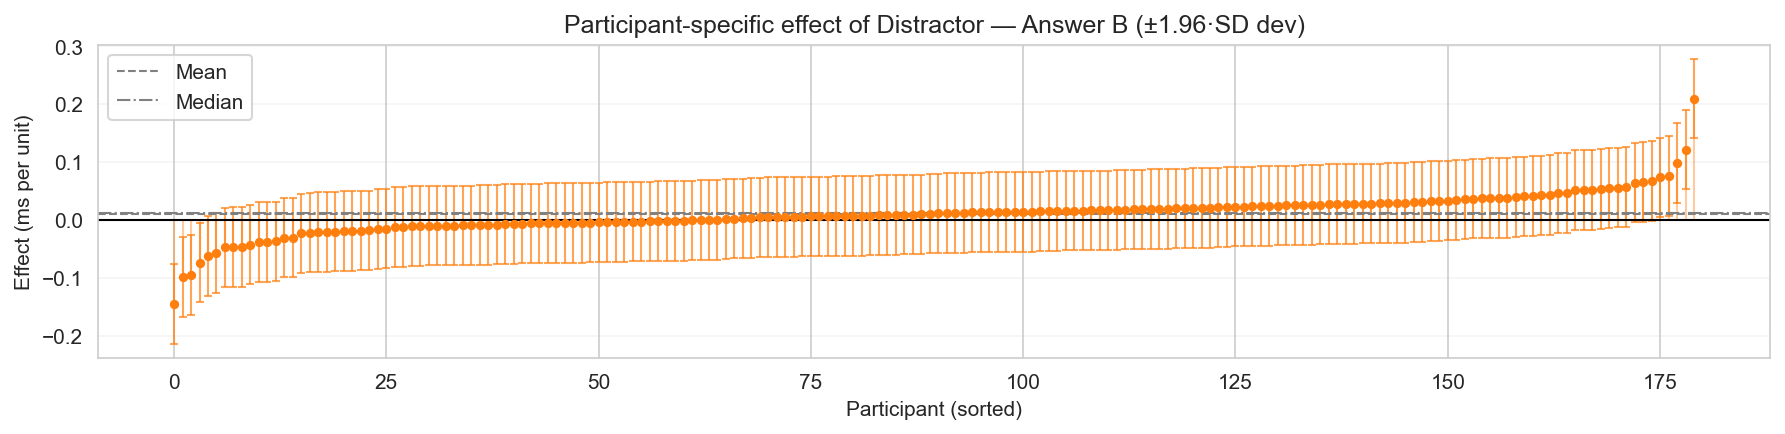

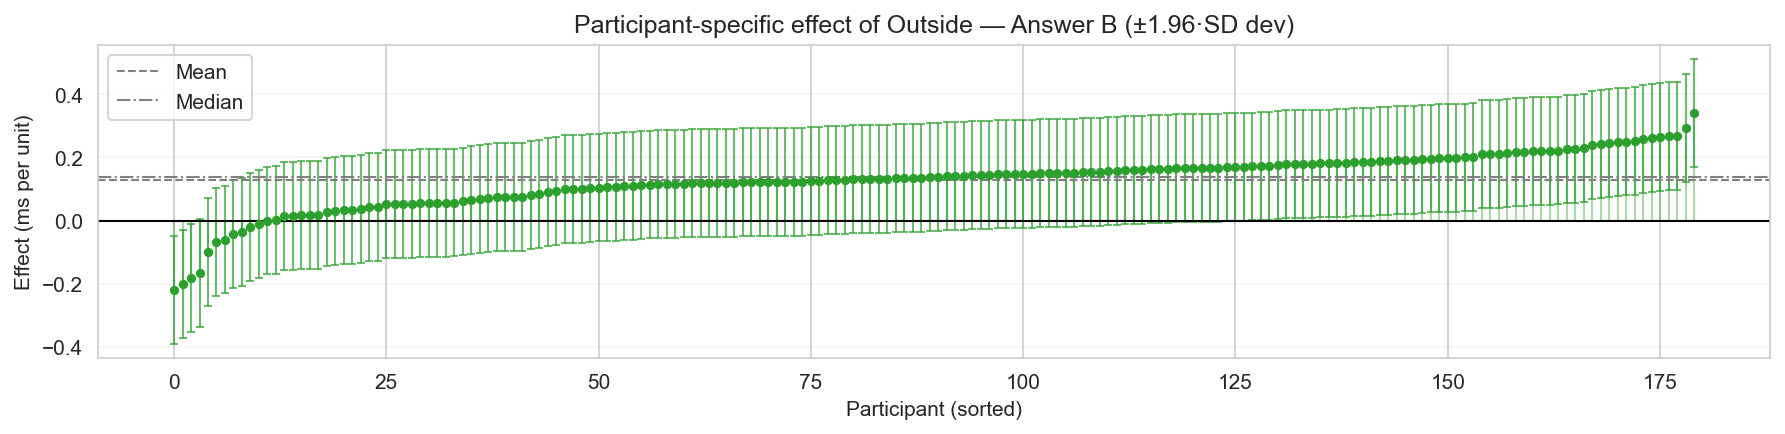


=== Answer C: fixed effects ===
critical     β=0.056 ± 0.045  p=0.01501 *
distractor   β=0.024 ± 0.029  p=0.1092 
outside      β=0.120 ± 0.049  p=4.086e-06 ***


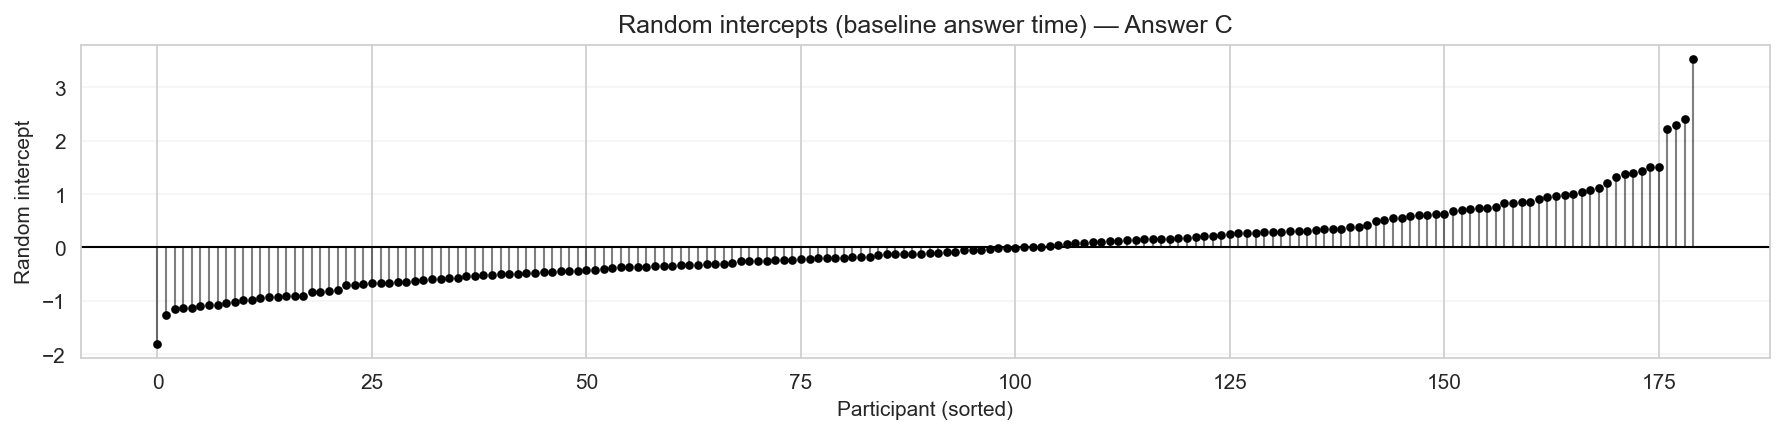

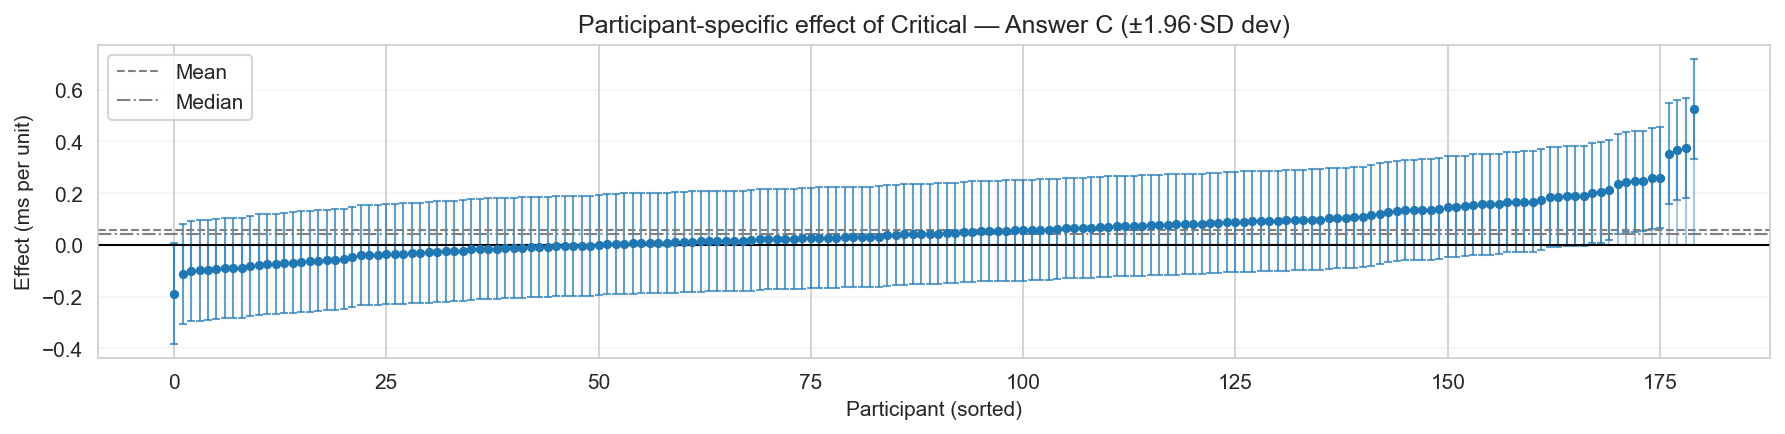

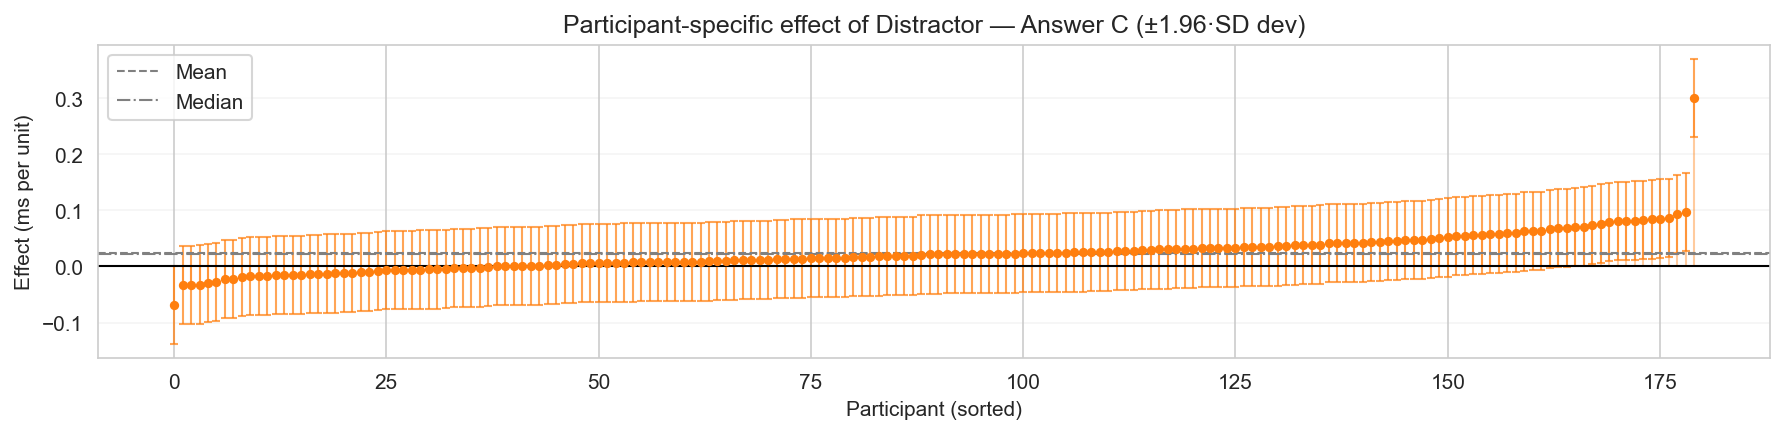

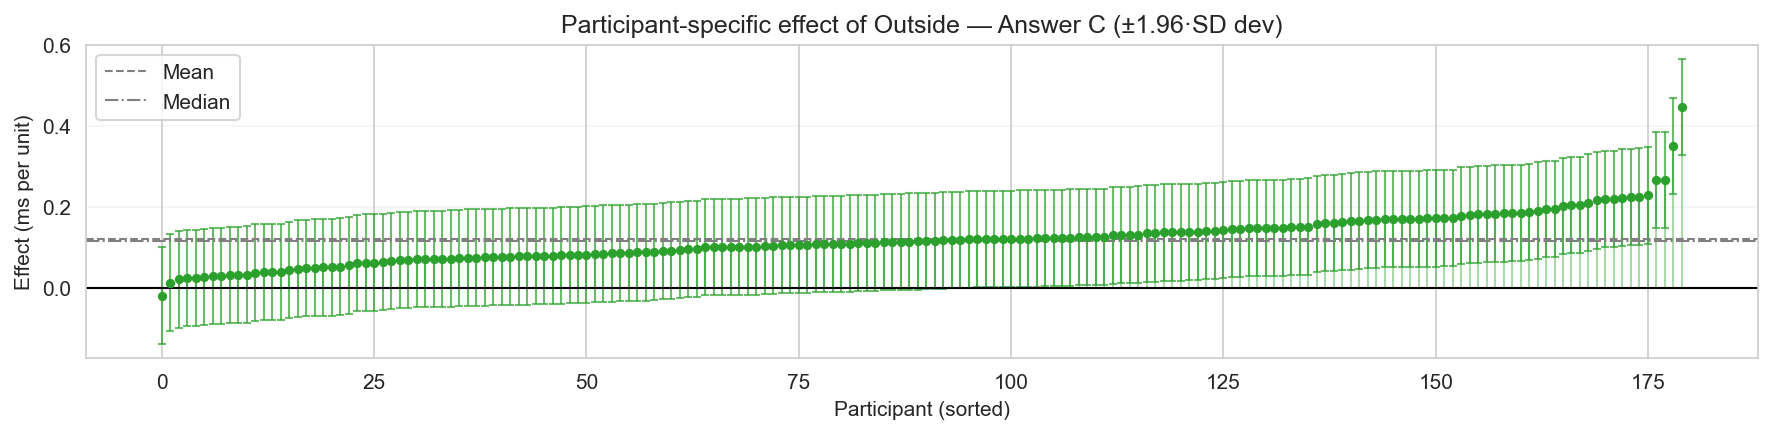


=== Answer D: fixed effects ===
critical     β=0.085 ± 0.039  p=2.936e-05 ***
distractor   β=0.017 ± 0.024  p=0.1502 
outside      β=0.130 ± 0.046  p=5.899e-08 ***


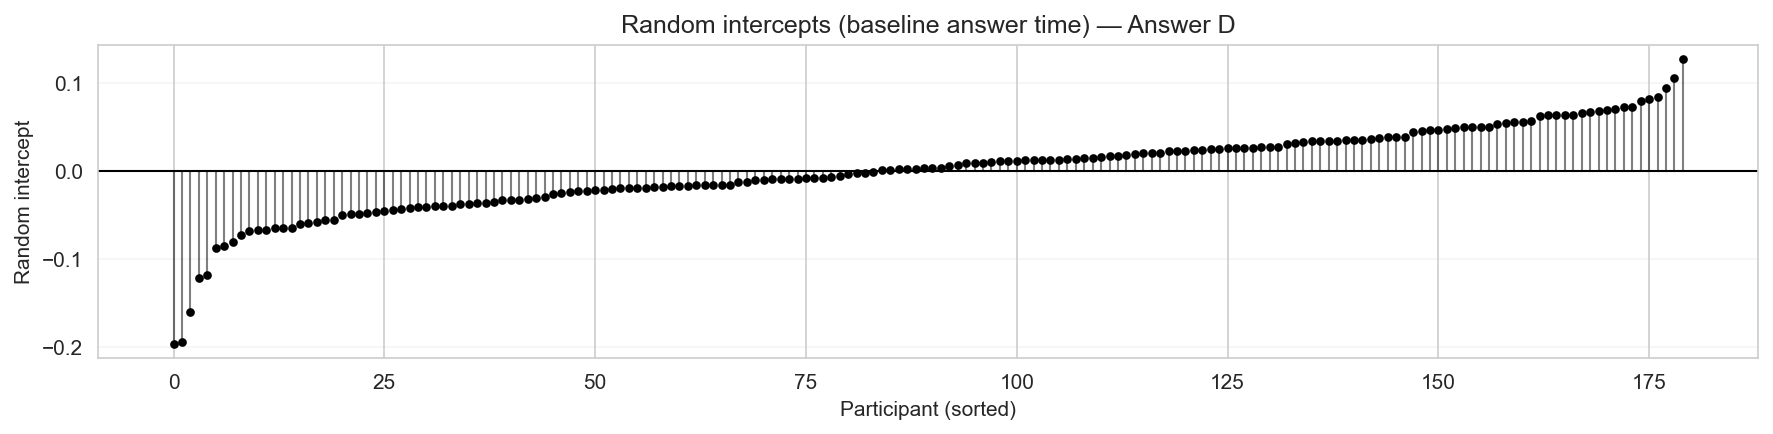

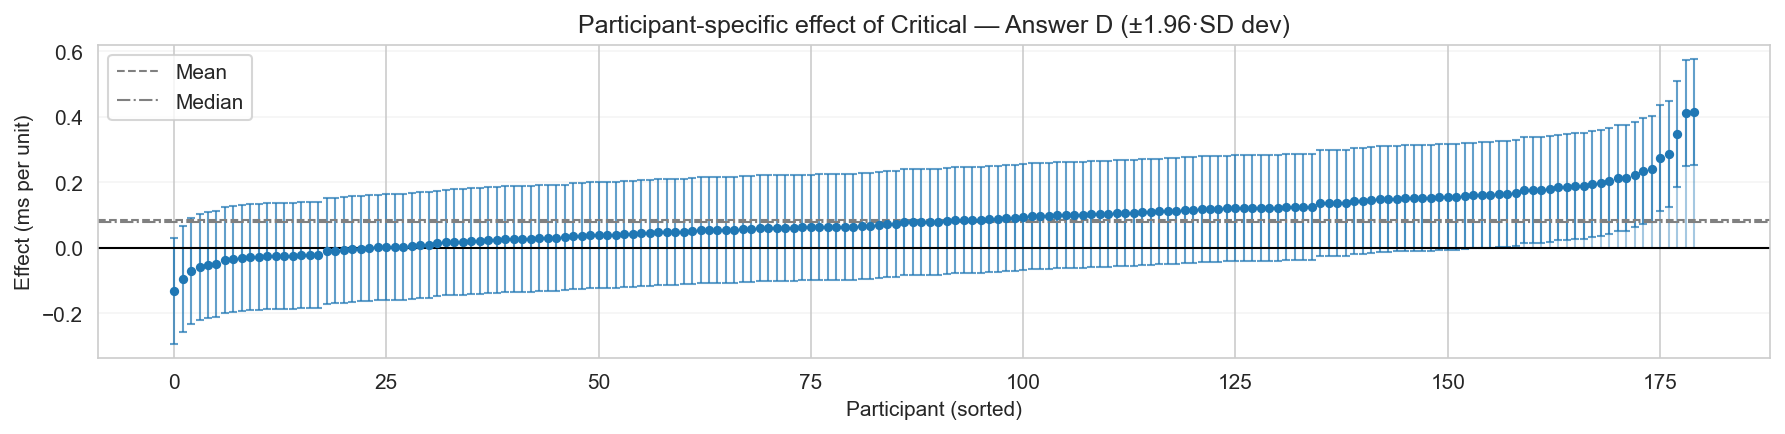

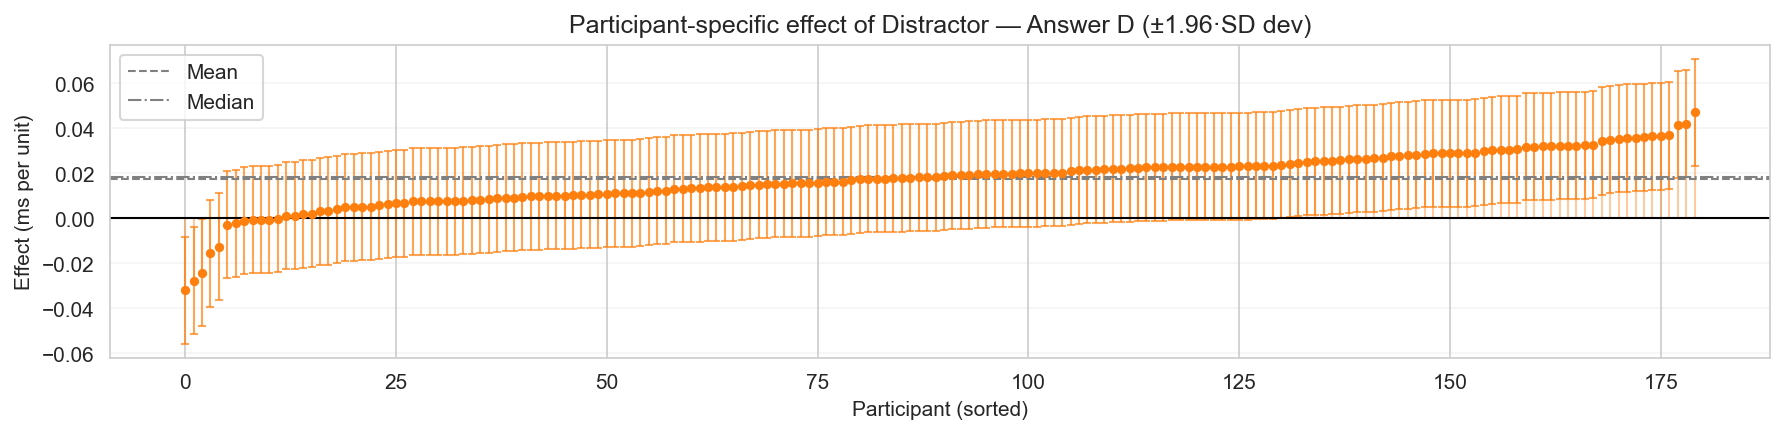

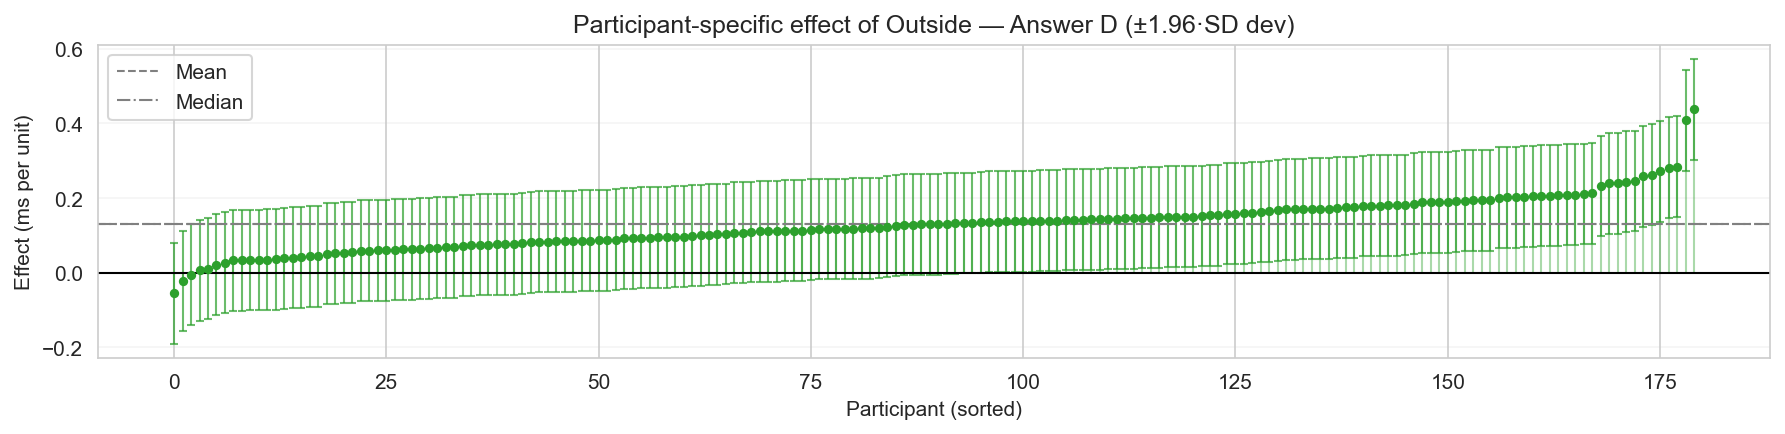

In [90]:
eff_Ag_all = plot_participant_effects(model_A_sloped_g_all, "Answer A")
eff_Bg_all = plot_participant_effects(model_B_sloped_g_all, "Answer B")
eff_Cg_all = plot_participant_effects(model_C_sloped_g_all, "Answer C")
eff_Dg_all = plot_participant_effects(model_D_sloped_g_all, "Answer D")